In [1]:
import numpy as np
from astropy import units as u, constants as const
from matplotlib import pyplot as plt
from scipy.stats import beta
from scipy.special import beta as betafct
from numba import jit, jitclass
from scipy import interpolate
from scipy.interpolate import interp1d
import logging

import sys
import os
sys.path.insert(1, '/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src')

import importlib
import simulation_strategies, collapse, plotting, utils
importlib.reload(simulation_strategies)
importlib.reload(collapse)
importlib.reload(plotting)
importlib.reload(utils)
from simulation_strategies import *
from collapse import *
from plotting import *
from utils import *

In [2]:
def my_mpl():
    plt.rc('font', family='serif', size=20)
    plt.rc('axes', grid=True)
    plt.rc('lines', lw=3)
    ts = 8
    plt.rc('xtick.minor', size=ts-2)
    plt.rc('ytick.minor', size=ts-2)
    plt.rc('xtick.major', size=ts)
    plt.rc('ytick.major', size=ts)
    plt.rc('figure', figsize=[12, 9])
my_mpl()
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [2]:
import cProfile
import pstats
# 't_max': 5.7,
# Create a SphericalCollapse instance
rho_H = 1/(6*np.pi)
delta_i = 0.01
tophat_radius = 1
config = {
    'softlen': 0,
    'density_strategy': 'const',
    'm_pert': 1,
    'tophat_radius': tophat_radius,
    'rho_bar': rho_H,
    'point_mass': 0,
    'safety_factor': 1e-4,
    'gamma': 0,
    'thickness_coef': 1,
    'j_coef': 0,
    'ang_mom_strategy': 'const',
    'energy_strategy': 'kin_softgrav_softrot',
    'accel_strategy': 'soft_le_delliou',
    't_max': 10,
    'dt_min': 1e-6,
    'N': 100,
    'r_min': 1e-2,
    'r_min_strategy': 'reflect',
    'H': 2/3,
    'r_max': 1.1,
    #'m_pert': rho_H * delta_i * 4*np.pi/3, 
    'stepper_strategy': 'beeman',
    'timescale_strategy': 'dyn',
    'm_enc_strategy': 'inclusive',
    'save_strategy': 'default',
    'save_dt': 1e-3,
    'deque_size': 1,
    'save_filename': None,
}
x = SphericalCollapse(config)
profile = True
if profile:
    # Profile the run method
    profiler = cProfile.Profile()
    profiler.enable()
    results = x.run()
    profiler.disable()

    # Print the profiling results
    stats = pstats.Stats(profiler).sort_stats('cumulative')
    stats.print_stats(20)  # Print top 20 time-consuming functions
else:
    results = x.run()


2024-10-23 00:05:50,833 - collapse - INFO - Simulation setup complete


Progress: 10%
Progress: 20%
Progress: 30%


KeyboardInterrupt: 

In [33]:
print(results['v'][0], (2/3)*results['r'][0])
print(results['m_enc'][0])
print(results['e_tot'][0])
print(results['m_enc'][0]/results['e_tot'][0])

[0.07333333 0.14666667 0.22       0.29333333 0.36666667 0.44
 0.51333333 0.58666667 0.66       0.73333333] [0.07333333 0.14666667 0.22       0.29333333 0.36666667 0.44
 0.51333333 0.58666667 0.66       0.73333333]
[0.001 0.008 0.027 0.064 0.125 0.216 0.343 0.512 0.729 1.   ]
[-6.40202020e-06 -1.79256566e-04 -1.09474545e-03 -3.78999596e-03
 -9.76308081e-03 -2.09730182e-02 -3.98397717e-02 -6.92442505e-02
 -1.12528309e-01 -1.73494747e-01]
[-156.20069423  -44.62876978  -24.66326751  -16.88656154  -12.80333559
  -10.29894687   -8.60948708   -7.3941157    -6.47836981   -5.76386326]


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divi

(-2.0, 1.0)

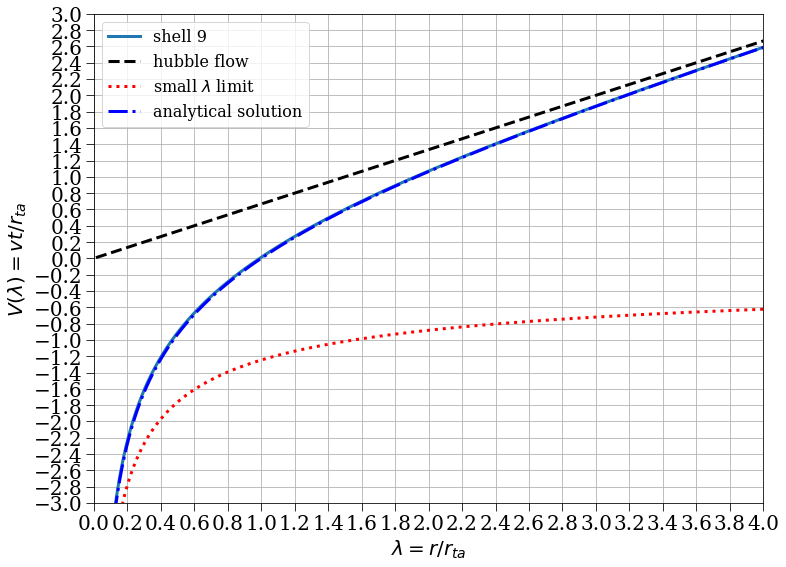

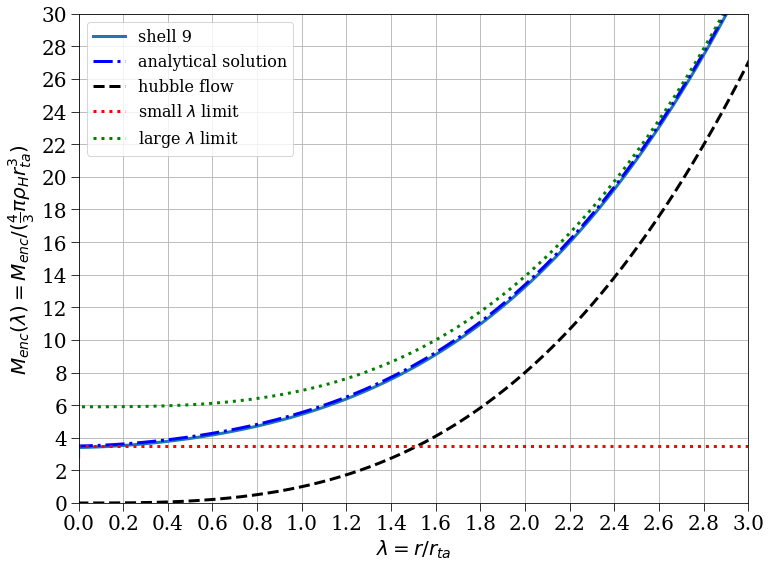

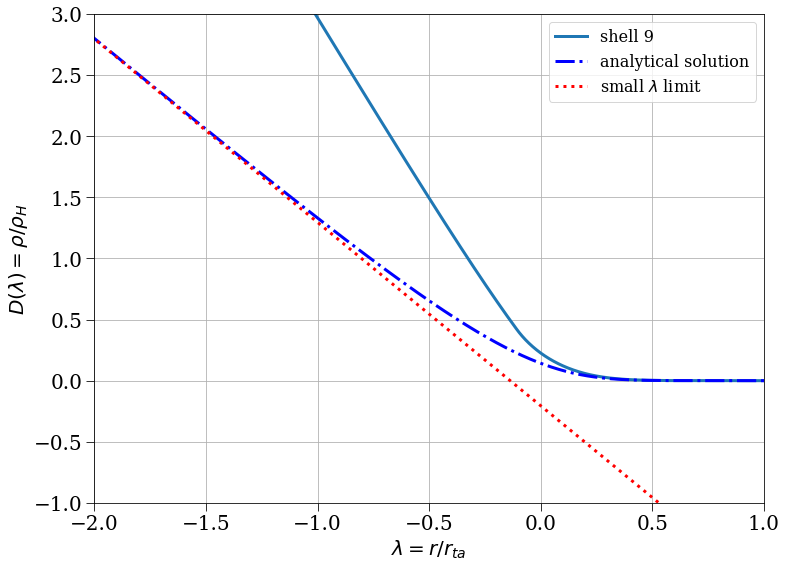

In [18]:
def lambda_analytical(theta):
    return np.sin(theta/2)**2 * ((theta-np.sin(theta))/np.pi)**(-8/9)
def v_analytical(theta):
    return lambda_analytical(theta) * (np.sin(theta)*(theta-np.sin(theta)))/(1-np.cos(theta))**2
def d_analytical(theta):
    return 3/4 * (theta - np.sin(theta))
def beta_analytical(theta):
    return np.sin(theta/2)**2
def m_enc_analytical(theta):
    return lambda_analytical(theta)**3 * d_analytical(theta)**2 * beta_analytical(theta)**(-3)
def chi_analytical(theta):
    return 1 - 3/2 * v_analytical(theta)/lambda_analytical(theta)
def density_analytical(theta):
    return d_analytical(theta)**2 * beta_analytical(theta)**(-3) / (1+3*chi_analytical(theta))
def rho_H_t(t):
    return rho_H * (1+t)**(-2)
theta = np.linspace(0, 2*np.pi, 1000)

tvals = results['t']
r_ta = (3*np.pi/4)**(-8/9) * (delta_i)**(1/3) * (1+tvals)**(8/9)
shell_indices = np.arange(0, results['r'].shape[1])

# for i in shell_indices:
#     if results['r'][:, i][0] >= 1:
#         plt.plot(results['t']+1, results['r'][:, i]/r_ta, label=f'shell {i}')
# plt.legend()
# plt.figure()

for i in shell_indices:
    if results['r'][:, i][0] >= tophat_radius:
        plt.plot(results['r'][:, i]/r_ta, results['v'][:, i]/r_ta * (1+results['t']), label=f'shell {i}')
plt.plot(lambda_analytical(theta), (2/3)*lambda_analytical(theta) , label=f'hubble flow', color='k', ls='--')
plt.plot(lambda_analytical(theta), -2**(-4/3)*np.pi*(lambda_analytical(theta))**(-1/2) , label=fr'small $\lambda$ limit', color='red', ls=':')


plt.plot(lambda_analytical(theta), v_analytical(theta), color='blue', ls='-.', label='analytical solution' )
plt.legend( fontsize=16)
plt.ylabel(r'$V(\lambda) = vt/r_{ta}$')
plt.xlabel(r'$\lambda = r/r_{ta}$')
ylo, yhi = -3, 3
xlo, xhi = 0, 4
plt.ylim(ylo, yhi)
plt.xlim(xlo, xhi)
plt.xticks(np.arange(0, xhi+0.2, 0.2))
plt.yticks(np.arange(ylo, yhi+0.2, 0.2))
plt.figure()
for i in shell_indices:
    if results['r'][:, i][0] >= 1:
        plt.plot(results['r'][:, i]/r_ta, results['m_enc'][:, i]/(4/3 * np.pi * rho_H_t(results['t']) * r_ta**3), label=f'shell {i}')
theta = np.linspace(0, 2*np.pi, 1000)
plt.plot(lambda_analytical(theta), m_enc_analytical(theta), color='blue', ls='-.', label='analytical solution')
plt.plot(lambda_analytical(theta), lambda_analytical(theta)**3, color='k', ls='--', label='hubble flow')
plt.plot(lambda_analytical(theta), np.ones_like(theta)*(3*np.pi/4)**2 * 2**(-2/3), label=fr'small $\lambda$ limit', color='red', ls=':')
plt.plot(lambda_analytical(theta), lambda_analytical(theta)**3 + 3/5 * (3*np.pi/4)**(8/3), label=fr'large $\lambda$ limit', color='green', ls=':')


plt.legend( fontsize=16)
plt.ylabel(r'$M_{enc}(\lambda) = M_{enc}/(\frac{4}{3} \pi \rho_{H} r_{ta}^3 )$')
plt.xlabel(r'$\lambda = r/r_{ta}$')
ylo, yhi = 0, 30
xlo, xhi = 0, 3
xspacing, yspacing = 0.2, 2
plt.ylim(ylo, yhi)
plt.xlim(xlo, xhi)
plt.xticks(np.arange(0, xhi+xspacing, xspacing))
plt.yticks(np.arange(ylo, yhi+yspacing, yspacing))
plt.figure()
for i in shell_indices:
    if results['r'][:, i][0] >= 1:
        volume = 4/3 * np.pi * (results['r'][:, i]**3 - results['r'][:, i-1]**3)
        mass = results['m_enc'][:, i] - results['m_enc'][:, i-1]
        rho = mass / volume
        plt.plot(np.log10(results['r'][:, i]/r_ta), np.log10(rho/rho_H_t(results['t'])), label=f'shell {i}')
plt.plot(np.log10(lambda_analytical(theta)), np.log10(density_analytical(theta)), color='blue', ls='-.', label='analytical solution')
plt.plot(np.log10(lambda_analytical(theta)), np.log10(2**(-7/3)*np.pi*lambda_analytical(theta)**(-3/2)), color='red', ls=':', label='small $\lambda$ limit')
plt.legend( fontsize=16)
plt.ylabel(r'$D(\lambda) = \rho/\rho_{H}$')
plt.xlabel(r'$\lambda = r/r_{ta}$')
ylo, yhi = -1, 3
xlo, xhi = -2, 1
xspacing, yspacing = 0.2, 0.2
plt.ylim(ylo, yhi)
plt.xlim(xlo, xhi)


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


<Figure size 864x648 with 0 Axes>

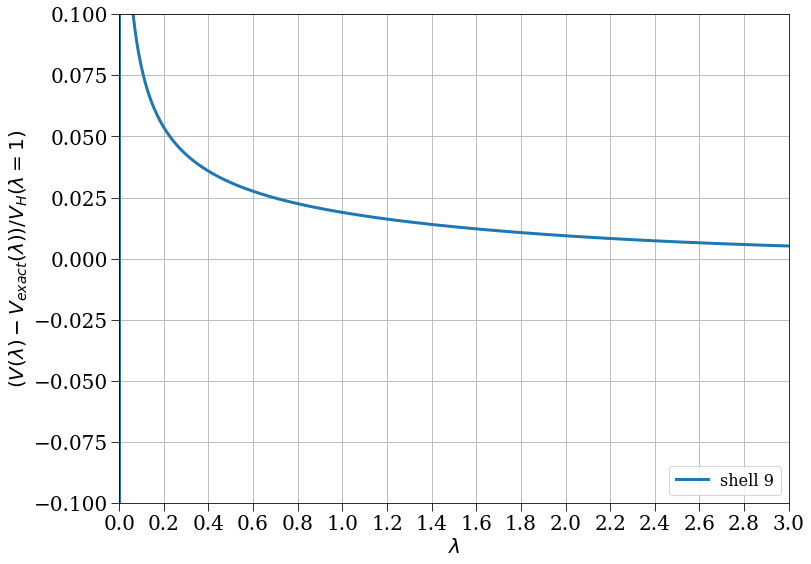

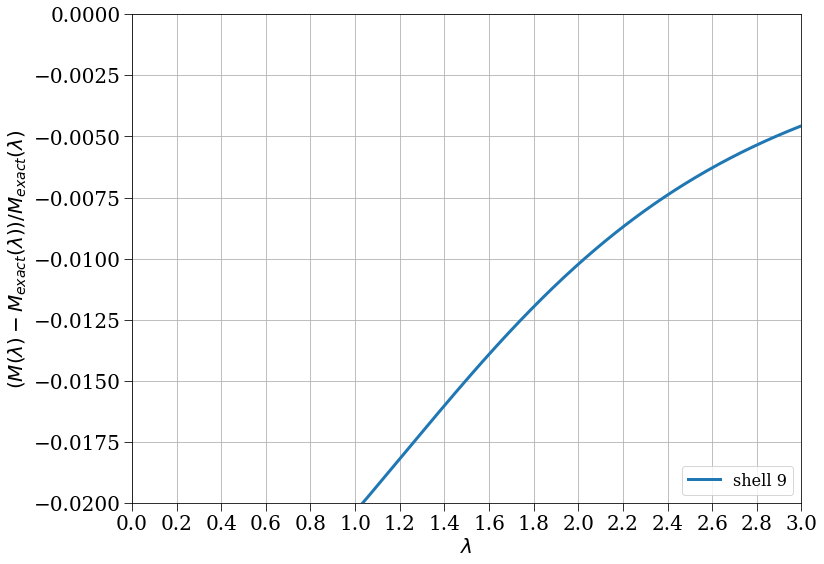

<Figure size 864x648 with 0 Axes>

In [19]:
theta = np.linspace(0, 2*np.pi, 10000)
lambda_vals = lambda_analytical(theta)
theta_from_lambda = interp1d(lambda_vals, theta)

shell_indices = np.arange(0, results['r'].shape[1])
for i in shell_indices:
    if results['r'][:, i][0] >= 1:
        lambda_vals = results['r'][:, i]/r_ta
        v_vals = results['v'][:, i]/r_ta * (1+results['t'])
        theta_vals = theta_from_lambda(lambda_vals)
        v_vals_analytical = v_analytical(theta_vals)
        plt.plot(lambda_vals, (v_vals-v_vals_analytical)/(2/3), label=f'shell {i}')

plt.legend(loc='lower right', fontsize=16)
plt.ylabel(r'$(V(\lambda)-V_{exact}(\lambda))/V_{H}(\lambda=1)$')
plt.xlabel(r'$\lambda$')
ylo, yhi = -0.1, 0.1
xlo, xhi = 0.2, 3
xspacing, yspacing = 0.2, 0.0002
plt.ylim(ylo, yhi)
plt.xlim(xlo, xhi)
plt.xticks(np.arange(0, xhi+xspacing, xspacing))
#plt.yticks(np.arange(ylo, yhi+yspacing, yspacing))
plt.figure()

shell_indices = np.arange(0, results['r'].shape[1])
for i in shell_indices:
    if results['r'][:, i][0] >= 1:
        lambda_vals = results['r'][:, i]/r_ta
        m_enc_vals = results['m_enc'][:, i]/(4/3 * np.pi * rho_H * r_ta**3 * (1+results['t'])**(-2))
        theta_vals = theta_from_lambda(lambda_vals)
        m_enc_vals_analytical = m_enc_analytical(theta_vals)
        plt.plot(lambda_vals, (m_enc_vals-m_enc_vals_analytical)/m_enc_vals_analytical, label=f'shell {i}')

plt.legend(loc='lower right', fontsize=16)
plt.ylabel(r'$(M(\lambda)-M_{exact}(\lambda))/M_{exact}(\lambda)$')
plt.xlabel(r'$\lambda$')
ylo, yhi = -0.02, 0
xlo, xhi = 0.2, 3
xspacing, yspacing = 0.2, 0.0002
plt.ylim(ylo, yhi)
plt.xlim(xlo, xhi)
plt.xticks(np.arange(0, xhi+xspacing, xspacing))
#plt.yticks(np.arange(ylo, yhi+yspacing, yspacing))
plt.figure()


[-0.03016615 -0.0301666  -0.0301666  ...         nan         nan
         nan]
[-0.00000000e+00  1.47036270e-05  1.47019041e-05 ...             nan
             nan             nan]
10.503892521657935
4675


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


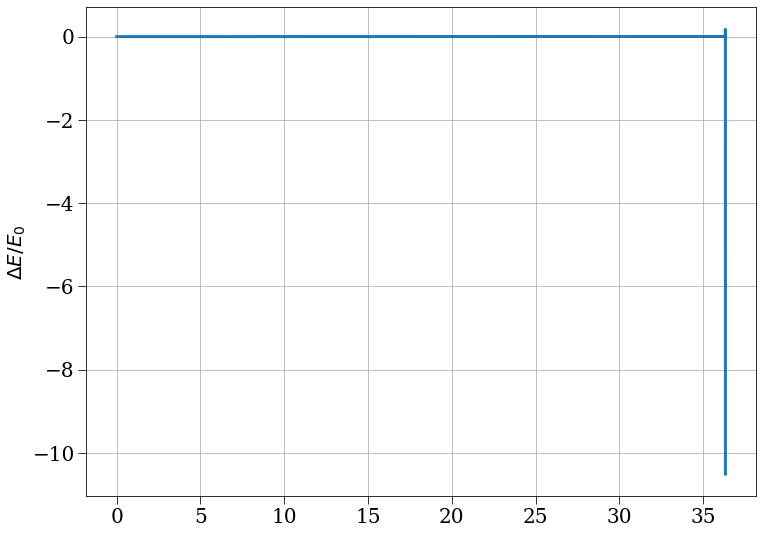

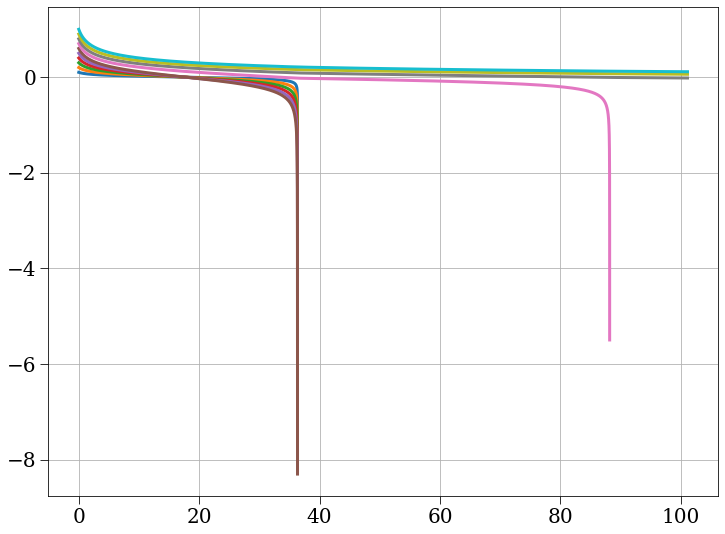

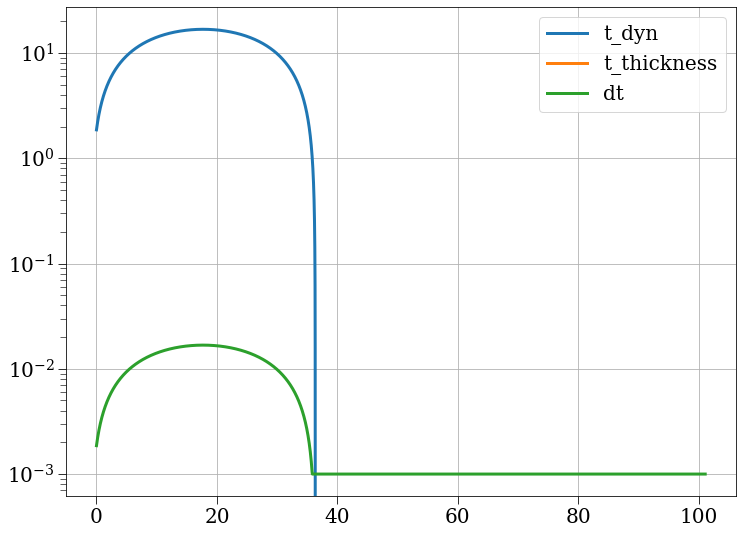

Error in callback <function flush_figures at 0x2aaadc862cb0> (for post_execute):


KeyboardInterrupt: 

In [7]:
total_energy_sum = np.sum(results['e_tot'], axis=1)
print(total_energy_sum)
reldif = (total_energy_sum - total_energy_sum[0]) / total_energy_sum[0]
print(reldif)
print(max(np.abs(reldif)))
amax = np.argmax(np.abs(reldif))
print(amax)
t_zoom = 1.111
amax = np.argmin(np.abs(results['t'] - t_zoom))

# print(results['t'][amax])
# around = int(1e5)
# start_idx = max(0, amax-around)
# end_idx = min(amax+around, len(results['t'])-1)

# Option to set start_idx and end_idx based on tzmin and tzmax
deltzoom = 100
tzmin = t_zoom - deltzoom  # Adjust this value as needed
tzmax = t_zoom + deltzoom  # Adjust this value as needed

# Find the indices where results['t'] is closest to tzmin and tzmax
start_idx = np.argmin(np.abs(results['t'] - tzmin))
end_idx = np.argmin(np.abs(results['t'] - tzmax))

# Ensure that start_idx is before end_idx
if start_idx > end_idx:
    start_idx, end_idx = end_idx, start_idx

# Add 1 to end_idx to include the last point when slicing
end_idx += 1


plt.plot(results['t'][start_idx:end_idx], reldif[start_idx:end_idx])
plt.ylabel(r'$\Delta E/E_0$')
plt.figure()
plt.plot(results['t'][start_idx:end_idx], results['v'][start_idx:end_idx], label='v')
plt.figure()
plt.plot(results['t'][start_idx:end_idx], results['t_dyn'][start_idx:end_idx], label='t_dyn')
plt.plot(results['t'][start_idx:end_idx], results['t_thickness'][start_idx:end_idx], label='t_thickness')
plt.plot(results['t'][start_idx:end_idx], results['dt'][start_idx:end_idx], label='dt')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'], results['r'][:, 0], label='inner')
plt.plot(results['t'], results['r'][:, -1], label='outer')
plt.legend()
plt.figure()
plt.plot(results['t'], results['r'][:, 0], label='inner')
plt.plot(results['t'], results['r'][:, -1], label='outer')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, 0], label='inner')
plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, -1], label='outer')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, 0], label='inner')
plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, -1], label='outer')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], results['e_tot'][start_idx:end_idx, 0], label='inner')
plt.plot(results['t'][start_idx:end_idx], results['e_tot'][start_idx:end_idx, -1], label='outer')
plt.ylabel(r'$E_{\rm shell}$')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], np.abs(results['e_k'][start_idx:end_idx, -1]), 'o', label='outer kinetic', ls='-')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], np.abs(results['e_g'][start_idx:end_idx, -1]), 'o',label='outer potential', ls='-')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], np.abs(results['e_r'][start_idx:end_idx, -1]), 'o',label='outer rotational', ls='-')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], np.abs(results['e_k'][start_idx:end_idx, 0]), 'o', label='inner kinetic', ls='-')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], np.abs(results['e_g'][start_idx:end_idx, 0]), 'o',label='inner potential', ls='-')
plt.yscale('log')
plt.legend()
plt.figure()
plt.plot(results['t'][start_idx:end_idx], np.abs(results['e_r'][start_idx:end_idx, 0]), 'o',label='inner rotational', ls='-')
plt.yscale('log')
plt.legend()
# Plot energy differences between inner and outer shells
energy_types = ['e_tot', 'e_k', 'e_g', 'e_r']
energy_labels = ['Total Energy', 'Kinetic Energy', 'Gravitational Potential Energy', 'Rotational Energy']

for e_type, e_label in zip(energy_types, energy_labels):
    plt.figure(figsize=(10, 6))
    energy_diff = np.abs(results[e_type][start_idx:end_idx, 0] + results[e_type][start_idx:end_idx, -1])
    plt.plot(results['t'][start_idx:end_idx], energy_diff, label=f'{e_label} sum')
    plt.xlabel('Time')
    plt.ylabel(f'{e_label} sum')
    plt.title(f'{e_label} sum between Inner and Outer Shells')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)


In [11]:
np.pi/np.sqrt(8)

1.1107207345395915

In [56]:
def shell_vol(r_o, r_i):
    volumes = 4/3 * np.pi * (r_o**3 - r_i**3)
    return volumes
m_pert = 1
r_max = 1
rho = m_pert / (4/3 * np.pi * r_max**3)
m_o = rho*shell_vol(1, 0.5)
m_i = rho*shell_vol(0.5, 0)
p_0 = m_i*results['v'][0, 0] + m_o*results['v'][0, -1]
print(p_0)

0.0


NameError: name 'm_i' is not defined

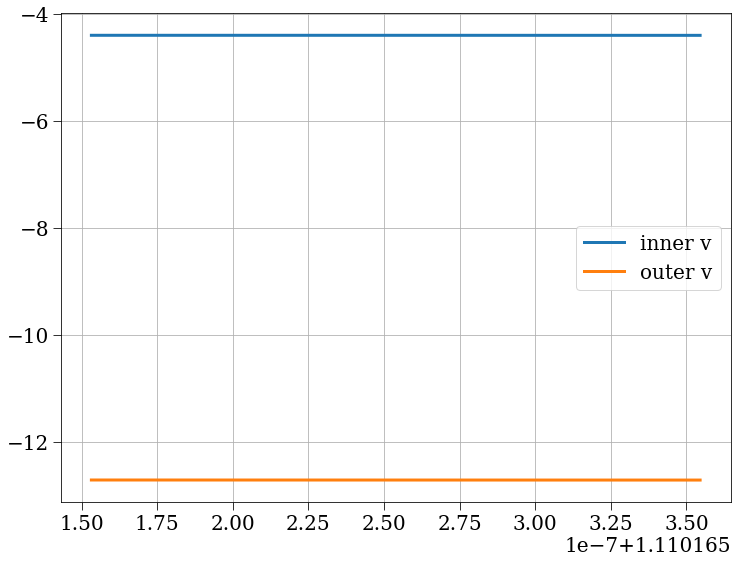

<Figure size 864x648 with 0 Axes>

In [7]:
# Function to plot with optional markers
def plot_with_optional_markers(x, y, label, use_markers=True):
    marker = 'o' if use_markers else None
    plt.plot(x, y, marker=marker, label=label, ls='-')

# Option to turn markers on/off
use_markers = False  # Set to False to turn off markers

# First plot
plot_with_optional_markers(results['t'][start_idx:end_idx], results['v'][start_idx:end_idx, 0], 'inner v', use_markers)
plot_with_optional_markers(results['t'][start_idx:end_idx], results['v'][start_idx:end_idx, -1], 'outer v', use_markers)
plt.legend()
plt.figure()

# Second plot
plot_with_optional_markers(results['t'][start_idx:end_idx], m_i*results['v'][start_idx:end_idx, 0], 'inner p', use_markers)
plot_with_optional_markers(results['t'][start_idx:end_idx], m_o*results['v'][start_idx:end_idx, -1], 'outer p', use_markers)
plot_with_optional_markers(results['t'][start_idx:end_idx], (m_i*results['v'][start_idx:end_idx, 0] + m_o*results['v'][start_idx:end_idx, -1]), 'p', use_markers)
plt.legend()
plt.figure()

# Third plot
plot_with_optional_markers(results['t'][start_idx:end_idx], np.abs(m_i*results['v'][start_idx:end_idx, 0] + m_o*results['v'][start_idx:end_idx, -1]), '|p|', use_markers)
plt.legend()

# Plot relative difference in velocity for both shells
plt.figure()

# Calculate relative difference for inner shell
inner_v_rel_diff = (results['v'][start_idx:end_idx, 0] - results['v'][start_idx, 0]) / results['v'][start_idx, 0]

# Calculate relative difference for outer shell
outer_v_rel_diff = (results['v'][start_idx:end_idx, -1] - results['v'][start_idx, -1]) / results['v'][start_idx, -1]

# Plot relative differences
plot_with_optional_markers(results['t'][start_idx:end_idx], inner_v_rel_diff, 'Inner shell', use_markers)
plot_with_optional_markers(results['t'][start_idx:end_idx], outer_v_rel_diff, 'Outer shell', use_markers)

plt.xlabel('Time')
plt.ylabel('Relative velocity difference')
plt.title('Relative Velocity Difference for Inner and Outer Shells')
plt.legend()
plt.grid(True)

plt.figure()
plot_with_optional_markers(results['t'][start_idx:end_idx], m_i*results['v'][start_idx:end_idx, 0], 'inner p', use_markers)
plt.legend()


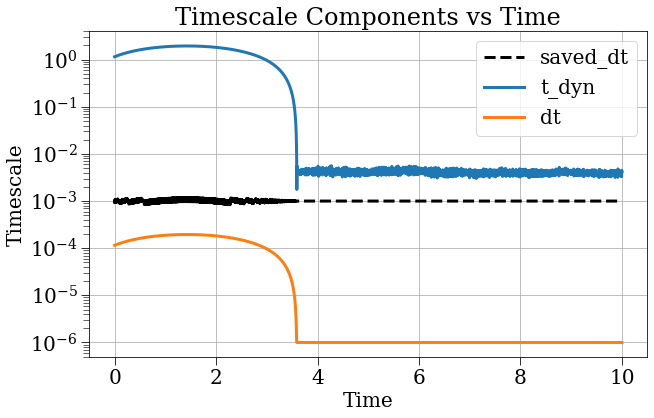

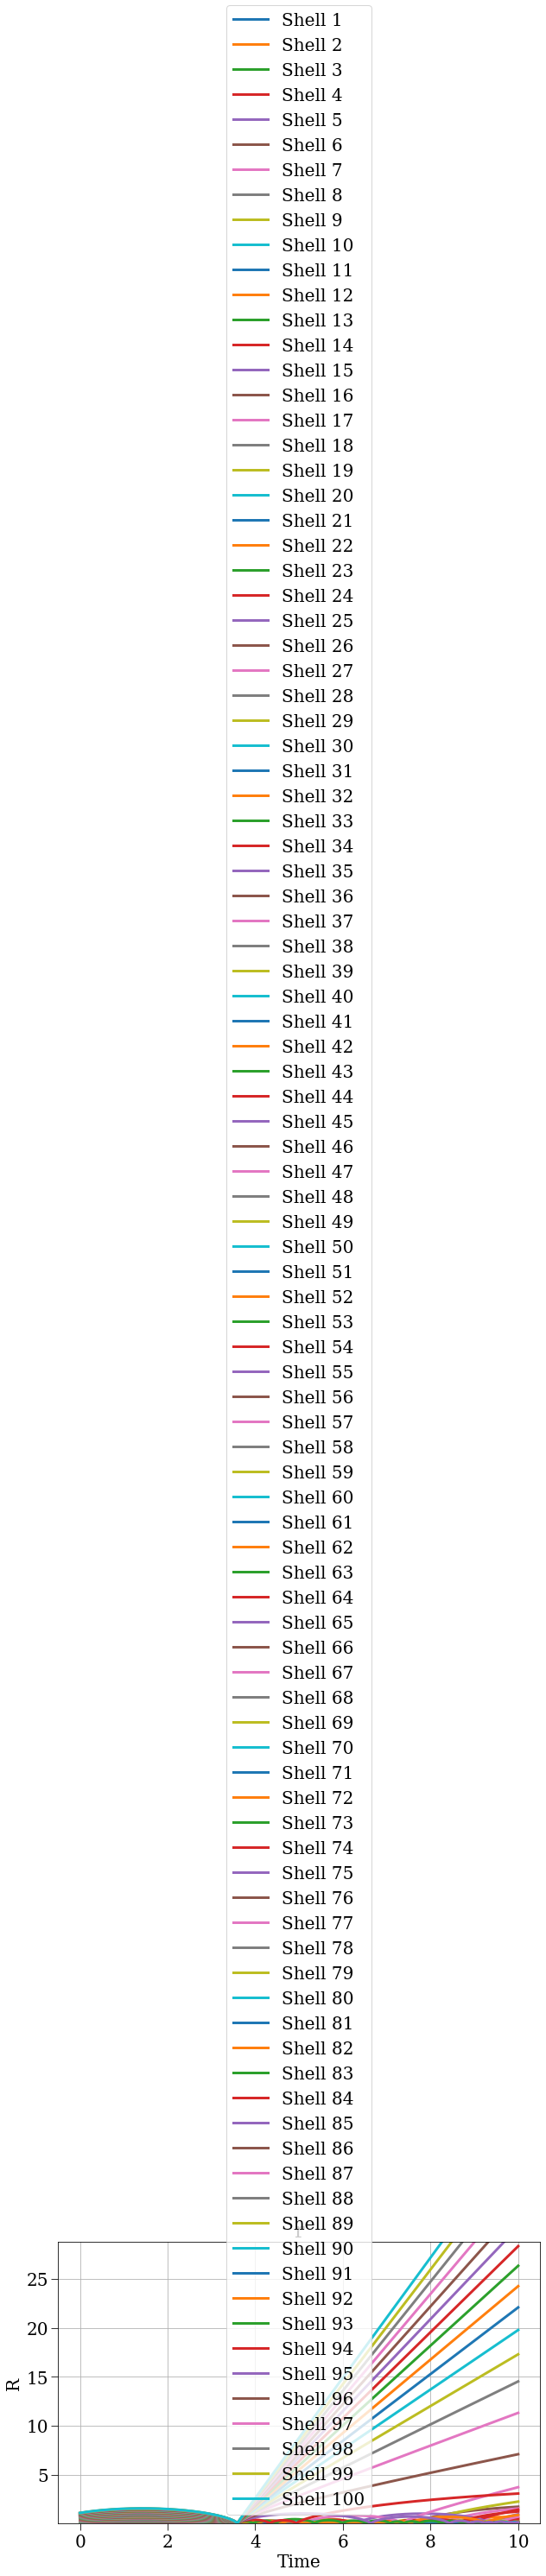

In [6]:
def plot_global_property(results, property_name, limit_axis=True, ylim=None):
    """
    Plot the progress of a global property over time.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - property_name: str, name of the property to plot ('t_dyn', 'e_tot', etc.)
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    if property_name not in results:
        raise ValueError(f"Property '{property_name}' not found in results.")
    
    time = results['t']
    property_data = results[property_name]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, property_data)
    plt.xlabel('Time')
    plt.ylabel(property_name.capitalize())
    plt.title(f'{property_name.capitalize()} vs Time')
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(property_data, 1)
        upper_percentile = np.percentile(property_data, 99)
        plt.ylim(lower_percentile, upper_percentile)
    
    

def plot_shell_property(results, property_name, shell_indices=None, num_shells=5, limit_axis=True, ylim=None, yscale='linear', title=None, vs_r=False, vs_rta=False):
    """
    Plot the progress of selected shells over time for a given property.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - property_name: str, name of the property to plot ('r', 'v', 'a', 'e_tot', 'e_g', 'e_k', 'e_r')
    - shell_indices: list of int, indices of shells to plot. If None, evenly spaced shells will be selected.
    - num_shells: int, number of shells to plot if shell_indices is None
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    if property_name not in results:
        raise ValueError(f"Property '{property_name}' not found in results.")
    
    time = results['t']
    property_data = results[property_name]
    if yscale == 'log':
        property_data = np.abs(property_data)
    
    if property_data.ndim == 1:
        # If the property is a global quantity, use plot_global_property instead
        return plot_global_property(results, property_name, limit_axis, ylim)
    
    if shell_indices is None:
        total_shells = property_data.shape[1]
        shell_indices = np.linspace(0, total_shells-1, min(total_shells, num_shells), dtype=int)
    
    plt.figure(figsize=(10, 6))
    for idx in shell_indices:
        if vs_r:
            plt.plot(results['r'][:, idx], property_data[:, idx], label=f'Shell {idx+1}')
        elif vs_rta:
            plt.plot(results['r'][:, idx]/(1+time)**(8/9), property_data[:, idx], label=f'Shell {idx+1}')
        else:
            plt.plot(time, property_data[:, idx], label=f'Shell {idx+1}')
    
    plt.yscale(yscale)
    plt.xlabel('Time' if not vs_r else 'Radius')
    plt.ylabel(property_name.capitalize())
    if title is None:
        plt.title(f'{property_name}')
    else:
        plt.title(title)
    plt.legend()
    plt.grid(True)
    
    try:
        if ylim:
            plt.ylim(ylim)
        elif limit_axis:
            data_to_plot = property_data[:, shell_indices]
            lower_percentile = 0.9*np.percentile(data_to_plot, 1)
            upper_percentile = 1.1*np.percentile(data_to_plot, 99)
            plt.ylim(lower_percentile, upper_percentile)
    except:
        pass
    
    

def plot_energy_components(results, shell_index=None, limit_axis=True, ylim=None):
    """
    Plot the progress of different energy components over time.
    If shell_index is provided, plot for a specific shell, otherwise plot global energy.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - shell_index: int or None, index of the shell to plot. If None, plot global energy.
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    time = results['t']
    energy_components = ['e_tot', 'e_g', 'e_k', 'e_r']
    
    plt.figure(figsize=(10, 6))
    all_energy_data = []
    for component in energy_components:
        if component in results:
            energy_data = results[component]
            if energy_data.ndim > 1 and shell_index is not None:
                energy_data = energy_data[:, shell_index]
            plt.plot(time, energy_data, label=component.capitalize())
            all_energy_data.extend(energy_data)
    
    plt.xlabel('Time')
    plt.ylabel('Energy')
    title = 'Energy Components vs Time'
    if shell_index is not None:
        title += f' for Shell {shell_index}'
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(all_energy_data, 1)
        upper_percentile = np.percentile(all_energy_data, 99)
        lower_limit = lower_percentile * 0.9 if lower_percentile > 0 else lower_percentile * 1.1
        upper_limit = upper_percentile * 1.1 if upper_percentile > 0 else upper_percentile * 0.9
        plt.ylim(lower_limit, upper_limit)
    
    


def plot_timescales(results, shell_index=None, limit_axis=False, ylim=None):
    """
    Plot the progress of different timescale components over time.
    If shell_index is provided, plot for a specific shell, otherwise plot global timescales.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - shell_index: int or None, index of the shell to plot. If None, plot global timescales.
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    """
    time = results['t']
    timescale_components = ['t_dyn', 't_vel', 't_acc', 't_cross', 't_zero', 't_rmin', 't_rmina', 't_dynnext', 't_dynr', 't_thickness', 'dt']
    
    plt.figure(figsize=(10, 6))
    plt.plot(time[:-1], np.diff(time), color='k', label='saved_dt', linestyle='--', zorder=99)
    all_timescale_data = []
    for component in timescale_components:
        if component in results and not all(x is None for x in results[component]):
            timescale_data = results[component]
            if timescale_data.ndim > 1 and shell_index is not None:
                timescale_data = timescale_data[:, shell_index]
            plt.plot(time, timescale_data, label=component)
            all_timescale_data.extend(timescale_data)
    
    plt.xlabel('Time')
    plt.ylabel('Timescale')
    title = 'Timescale Components vs Time'
    if shell_index is not None:
        title += f' for Shell {shell_index}'
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    plt.yscale('log')  # Set y-axis to logarithmic scale
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(all_timescale_data, 1)
        upper_percentile = np.percentile(all_timescale_data, 99)
        plt.ylim(lower_percentile, upper_percentile)
    
    

def plot_total_energy_relative_change(results, limit_axis=True, ylim=None, yscale='linear'):
    """
    Plot the relative change of the sum of total energies of all individual shells over time,
    compared to the initial total energy.
    
    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - limit_axis: bool, whether to limit the y-axis to exclude extreme values
    - ylim: tuple, custom y-axis limits (min, max)
    - yscale: str, scale of y-axis ('linear', 'log', 'symlog', etc.)
    """
    time = results['t']
    e_tot = results['e_tot']
    
    # Calculate the sum of total energies for all shells at each time step
    total_energy_sum = np.sum(e_tot, axis=1)
    
    # Get the initial total energy
    initial_total_energy = total_energy_sum[0]
    
    # Calculate the relative change compared to the initial energy
    relative_change = (total_energy_sum - initial_total_energy) / initial_total_energy
    if yscale == 'log':
        relative_change = np.abs(relative_change)
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, relative_change)
    plt.xlabel('Time')
    plt.ylabel('Relative Change in Total Energy')
    plt.title(r'$\Delta E/E_0$')
    plt.grid(True)
    
    plt.yscale(yscale)  # Set y-axis scale
    
    if ylim:
        plt.ylim(ylim)
    elif limit_axis:
        lower_percentile = np.percentile(relative_change, 1)
        upper_percentile = np.percentile(relative_change, 99)
        lower_limit = lower_percentile * 0.9 if lower_percentile > 0 else lower_percentile * 1.1
        upper_limit = upper_percentile * 1.1 if upper_percentile > 0 else upper_percentile * 0.9
        plt.ylim(lower_limit, upper_limit)

# Example usage:
plot_timescales(results)
#plot_global_property(results, 'e_tot')
shells = np.arange(100)#[0,24,49,74,99]


plot_shell_property(results, 'r', ylim=None, shell_indices=shells)
plot_shell_property(results, 'r', yscale='log', limit_axis=False, shell_indices=shells)
plot_shell_property(results, 'v', vs_rta=True, shell_indices=shells, ylim=[-2, 2])
plot_shell_property(results, 'e_g', shell_indices=shells)
#plot_global_property(results, 'num_crossing', limit_axis=False)
plot_total_energy_relative_change(results, limit_axis=False, yscale='linear',)
plot_total_energy_relative_change(results, limit_axis=False, yscale='log', ylim=[1e-2, None])
#plot_shell_property(results, 'v')
plot_shell_property(results, 'm_enc', limit_axis=False, shell_indices=shells)
plot_shell_property(results, 'v', limit_axis=False, shell_indices=shells)
plot_shell_property(results, 'a', limit_axis=False, shell_indices=shells)
plot_shell_property(results, 'm_enc', limit_axis=False, shell_indices=shells, vs_r=True)
plot_shell_property(results, 'v', limit_axis=False, shell_indices=shells, vs_r=True)
plot_shell_property(results, 'a', limit_axis=False, shell_indices=shells, vs_r=True)
plot_energy_components(results, shell_index=0, limit_axis=False)  # Plot energy for a specific shell
plot_energy_components(results, shell_index=-1, limit_axis=False)  # Plot energy for a specific shell
#analyze_energy_conservation(results)



In [104]:
def visualize_rebound_moments(results, shell_index=0, window_before=10, window_after=10):
    """
    Visualize parameters around the rebound moments of a specific shell.

    Parameters:
    - results: dict, output from SphericalCollapse.run()
    - shell_index: int, index of the shell to analyze
    - window_before: int, number of time steps before the rebound
    - window_after: int, number of time steps after the rebound

    This function identifies all rebound moments for the specified shell and plots
    the parameters r, v, a, and energies around each rebound without overlapping windows.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract relevant data
    t = results['t']
    r = results['r'][:, shell_index]
    v = results['v'][:, shell_index]
    a = results['a'][:, shell_index]
    e_tot = results['e_tot'][:, shell_index]
    e_k = results['e_k'][:, shell_index]
    e_g = results['e_g'][:, shell_index]
    e_r = results['e_r'][:, shell_index]

    # Identify rebound moments (velocity crosses from negative to positive)
    rebound_indices = np.where((v[:-1] < 0) & (v[1:] >= 0))[0] + 1  # +1 for the crossing point

    print(f"Found {len(rebound_indices)} rebound moments for shell {shell_index}.")

    # To prevent overlapping windows, keep track of the last plotted index
    last_plotted = -np.inf

    for idx, rebound_idx in enumerate(rebound_indices):
        # Check if current rebound is outside the previous window
        if rebound_idx - window_before <= last_plotted:
            print(f"Skipping rebound {idx+1} at index {rebound_idx} to prevent overlapping windows.")
            continue

        # Define the window around the rebound
        start = rebound_idx - window_before
        end = rebound_idx + window_after + 1

        # Ensure indices are within the data range
        if start < 0:
            start = 0
            print(f"Rebound {idx+1}: Adjusted start from {rebound_idx - window_before} to {start}.")
        if end > len(t):
            end = len(t)
            print(f"Rebound {idx+1}: Adjusted end from {rebound_idx + window_after +1} to {end}.")

        # Time range
        t_window = t[start:end]

        # Parameters in the window
        r_window = r[start:end]
        v_window = v[start:end]
        a_window = a[start:end]
        e_tot_window = e_tot[start:end]
        e_k_window = e_k[start:end]
        e_g_window = e_g[start:end]
        e_r_window = e_r[start:end]

        # Debugging: Print the number of points before and after
        actual_before = rebound_idx - start
        actual_after = end - rebound_idx
        print(f"Rebound {idx+1}: {actual_before} points before, {actual_after} points after.")

        # Create subplots
        fig, axs = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
        fig.suptitle(f'Shell {shell_index} Rebound {idx+1} at t ≈ {t[rebound_idx]:.4f}', fontsize=16)

        # Radius vs Time
        axs[0].plot(t_window, r_window, label='Radius (r)', marker='o', linestyle='-')
        axs[0].axvline(t[rebound_idx], color='r', linestyle='--', label='Rebound')
        axs[0].set_ylabel('Radius')
        axs[0].legend()
        axs[0].grid(True)

        # Velocity vs Time
        axs[1].plot(t_window, v_window, label='Velocity (v)', color='g', marker='o', linestyle='-')
        axs[1].axvline(t[rebound_idx], color='r', linestyle='--', label='Rebound')
        axs[1].set_ylabel('Velocity')
        axs[1].legend()
        axs[1].grid(True)

        # Acceleration vs Time
        axs[2].plot(t_window, a_window, label='Acceleration (a)', color='m', marker='o', linestyle='-')
        axs[2].axvline(t[rebound_idx], color='r', linestyle='--', label='Rebound')
        axs[2].set_ylabel('Acceleration')
        axs[2].legend()
        axs[2].grid(True)

        # Energies vs Time
        axs[3].plot(t_window, e_tot_window, label='Total Energy (E_tot)', marker='o', linestyle='-')
        axs[3].plot(t_window, e_k_window, label='Kinetic Energy (E_k)', marker='o', linestyle='-')
        axs[3].plot(t_window, e_g_window, label='Gravitational Energy (E_g)', marker='o', linestyle='-')
        axs[3].plot(t_window, e_r_window, label='Rotational Energy (E_r)', marker='o', linestyle='-')
        axs[3].axvline(t[rebound_idx], color='r', linestyle='--', label='Rebound')
        axs[3].set_ylabel('Energy')
        axs[3].legend()
        axs[3].grid(True)

        # Calculate the absolute value of total energy divided by total energy at time step zero
        e_tot_normalized = np.abs(e_tot_window) / np.abs(e_tot[0])
        
        # Plot the normalized total energy
        axs[4].plot(t_window, e_tot_normalized, label='Normalized Total Energy', color='b', marker='o', linestyle='-')
        axs[4].axvline(t[rebound_idx], color='r', linestyle='--', label='Rebound')
        axs[4].set_ylabel('Normalized Total Energy')
        axs[4].set_xlabel('Time')
        axs[4].legend()
        axs[4].grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Update the last plotted index
        last_plotted = end

In [105]:
print(min(results['r']))

[5.00000492e-07]


Found 1 rebound moments for shell 0.
Rebound 1: 5 points before, 6 points after.


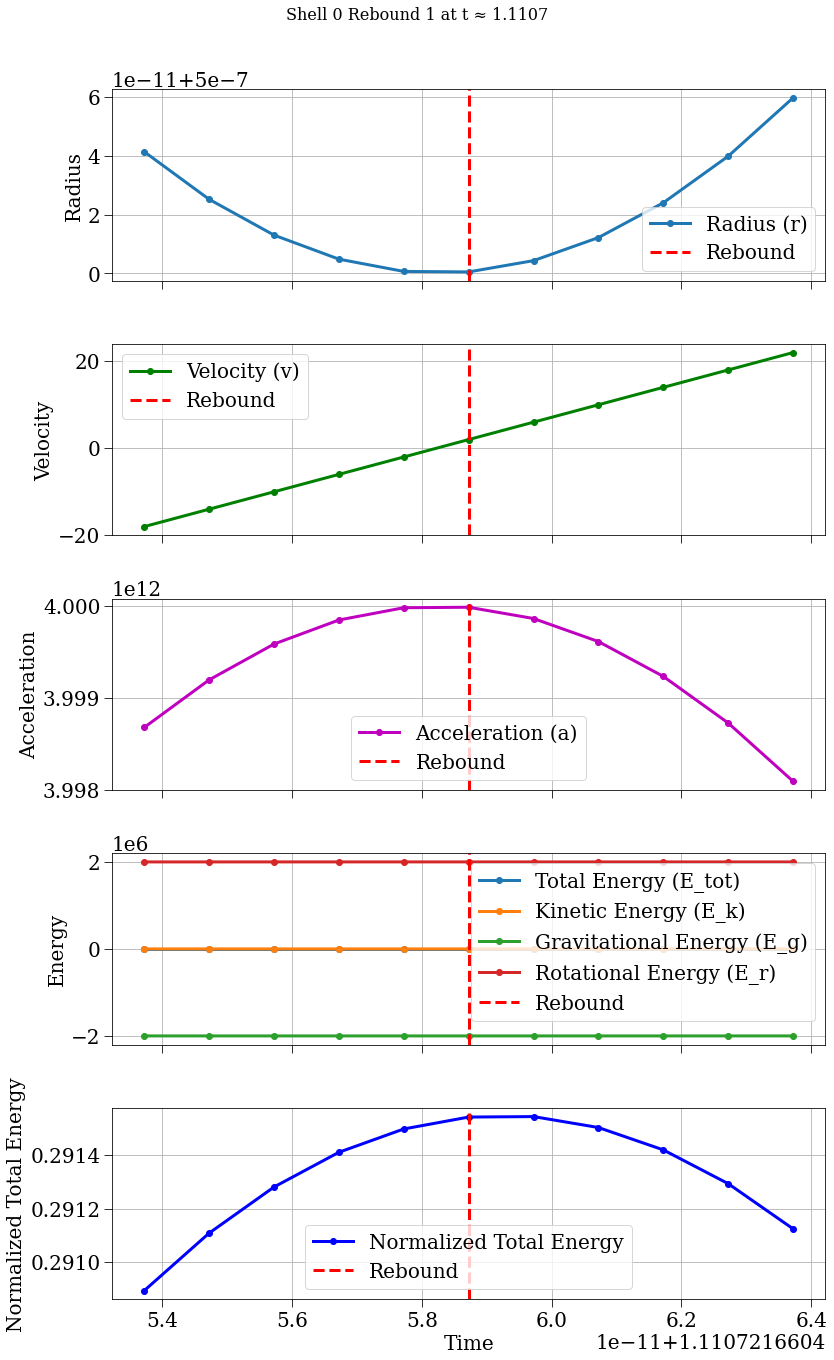

In [106]:
visualize_rebound_moments(results, shell_index=0, window_before=5, window_after=5)
#visualize_rebound_moments(results, shell_index=1, window=10)

In [107]:
results['deque'].shape

(23057,)

In [116]:
def visualize_pre_rebound(results, shell_index=0, num_after_rebound=1):
    """
    Visualize the moments before a rebound using the deque snapshots.

    Parameters:
    - deque_snapshots: list of dict
        The list containing the recent simulation snapshots leading up to a rebound.
    - shell_index: int, default=0
        Index of the shell to analyze.
    - window_size: int, default=3
        Number of snapshots to plot before the rebound.
    """
    # Extract relevant data
    t = results['t']
    r = results['r'][:, shell_index]
    v = results['v'][:, shell_index]
    a = results['a'][:, shell_index]
    e_tot = results['e_tot'][:, shell_index]
    e_k = results['e_k'][:, shell_index]
    e_g = results['e_g'][:, shell_index]
    e_r = results['e_r'][:, shell_index]

    # Identify rebound moments (velocity crosses from negative to positive)
    rebound_index = np.where((v[:-1] < 0) & (v[1:] >= 0))[0] + 1  # +1 for the crossing point
    deque = results['deque'][rebound_index + num_after_rebound][0]
    
    # Extract data for plotting
    times = [deque[i]['t'] for i in range(len(deque))]
    radii = [deque[i]['r'][shell_index] for i in range(len(deque))]
    velocities = [deque[i]['v'][shell_index] for i in range(len(deque))]
    accelerations = [deque[i]['a'][shell_index] for i in range(len(deque))]
    e_tot = [deque[i]['e_tot'][shell_index] for i in range(len(deque))]
    e_g = [deque[i]['e_g'][shell_index] for i in range(len(deque))]
    e_k = [deque[i]['e_k'][shell_index] for i in range(len(deque))]
    e_r = [deque[i]['e_r'][shell_index] for i in range(len(deque))]

    rebound_time = results['t'][rebound_index][0]
    rebound_r = results['r'][rebound_index][0, shell_index]
    rebound_v = results['v'][rebound_index][0, shell_index]

    
    # Calculate the sum of total energies for all shells at each time step
    initial_total_energy = np.sum(results['e_tot'], axis=1)[0]
    
    # Calculate the relative change compared to the initial energy
    e_tot_rel = (e_tot - initial_total_energy) / initial_total_energy

    # Plotting
    fig, axs = plt.subplots(5, 1, figsize=(12, 24), sharex=True)
    print(rebound_time)
    fig.suptitle(f'Shell {shell_index} Moments Before Rebound at t ≈ {rebound_time:.4f}', fontsize=18)

    # Radius vs Time
    axs[0].plot(times, radii, marker='o', linestyle='-', color='blue', label='Radius (r)')
    axs[0].axvline(x=rebound_time, color='red', linestyle='--', label='Rebound')
    axs[0].set_ylabel('Radius')
    axs[0].legend(fontsize=10)  # Smaller fontsize for legend

    # Velocity vs Time
    axs[1].plot(times, velocities, marker='o', linestyle='-', color='green', label='Velocity (v)')
    axs[1].axvline(x=rebound_time, color='red', linestyle='--', label='Rebound')
    axs[1].set_ylabel('Velocity')
    axs[1].legend(fontsize=10)  # Smaller fontsize for legend

    # Acceleration vs Time
    axs[2].plot(times, accelerations, marker='o', linestyle='-', color='purple', label='Acceleration (a)')
    axs[2].axvline(x=rebound_time, color='red', linestyle='--', label='Rebound')
    axs[2].set_ylabel('Acceleration')
    axs[2].legend(fontsize=10)  # Smaller fontsize for legend

    # Energies vs Time
    axs[3].plot(times, np.abs(e_tot), marker='o', linestyle='-', label='Total Energy (E_tot)')
    axs[3].plot(times, np.abs(e_k), marker='o', linestyle='--', label='Kinetic Energy (E_k)')
    axs[3].plot(times, np.abs(e_g), marker='o', linestyle='-.', label='Gravitational Energy (E_g)')
    axs[3].plot(times, np.abs(e_r), marker='o', linestyle=':', label='Rotational Energy (E_r)')
    axs[3].axvline(x=rebound_time, color='red', linestyle='--', label='Rebound')
    axs[3].set_ylabel('Energy (Absolute Value)')
    axs[3].set_yscale('log')
    axs[3].legend(fontsize=10)  # Smaller fontsize for legend

    # Relative Total Energy vs Time
    axs[4].plot(times, e_tot_rel, marker='o', linestyle='-', color='orange', label='Relative Total Energy')
    axs[4].axvline(x=rebound_time, color='red', linestyle='--', label='Rebound')
    axs[4].set_ylabel('Relative Total Energy')
    axs[4].set_xlabel('Time')
    axs[4].legend(fontsize=10)  # Smaller fontsize for legend

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"Rebound occurred at t = {rebound_time:.6f}")
    print(f"Radius at rebound: {rebound_r:.6f}")
    print(f"Velocity at rebound: {rebound_v:.6f}")

1.1107216604587196


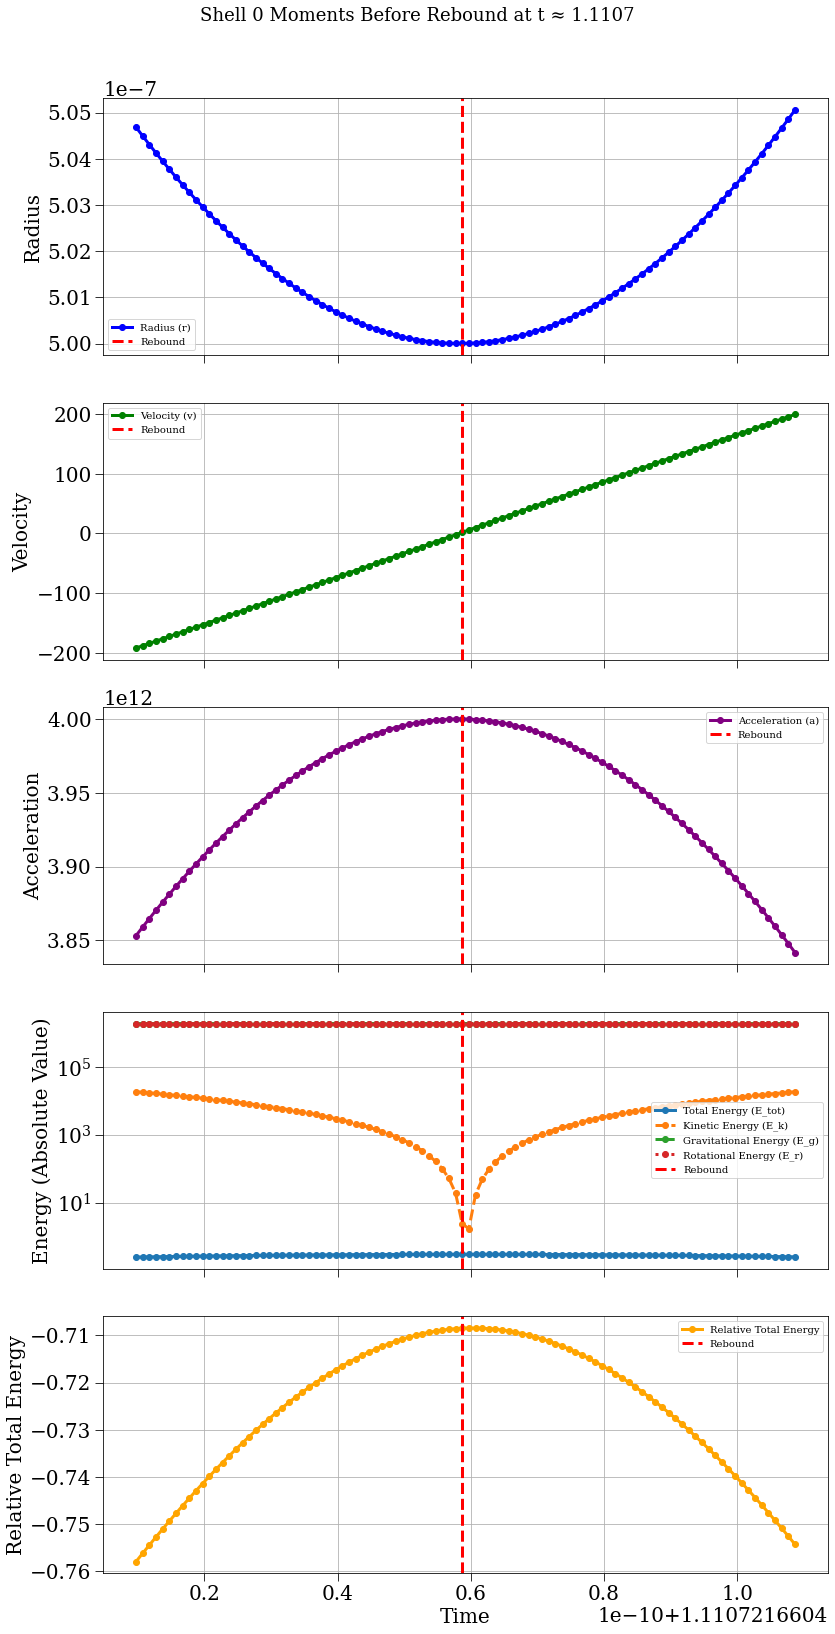

Rebound occurred at t = 1.110722
Radius at rebound: 0.000001
Velocity at rebound: 1.830553


In [117]:
visualize_pre_rebound(results, shell_index=0, num_after_rebound=50)
#visualize_pre_rebound(results, shell_index=1)

In [ ]:
def test_r_t_comparison(base_config, m, H, r, J):
    """
    Test the simulation's r(t) against a numerically solved r(t) using scipy.
    """
    initial_conditions = [r, H * r]  # [r(0), v(0)]

    def acceleration(t, y):
        r, v = y
        a = -G * m / r**2 + (J ** 2) / r**3
        return [v, a]
    
    # Define test parameters
    G = 1
    M = m
    # Calculate analytical values
    v = H * r
    L = J * m
    E_k = (1/2)*m*v**2
    E_g = -G*m*M/r
    E_rot = L**2/(2*m*r**2)
    E_tot = E_k + E_g + E_rot
    a = -E_tot
    b = -G*M*m
    c = L**2/(2*m)
    r_close_analytical = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
    r_close_analytical = np.nanmin([r_close_analytical, r])
    r_far_analytical = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
    r_far_analytical = np.nanmax([r_far_analytical, r])
    t_max = np.sqrt(4*np.pi/m * r_far_analytical**3)
    print(t_max)

    # Time span for the simulation
    t_span = (0, t_max)
    t_eval = np.linspace(t_span[0], t_span[1], int(t_max / base_config["save_dt"]) + 1)

    # Solve ODE numerically
    sol = solve_ivp(acceleration, t_span, initial_conditions, t_eval=t_eval, method='RK45', rtol=1e-8)

    if not sol.success:
        pytest.fail("ODE solver failed to integrate.")

    r_numerical = sol.y[0]
    v_numerical = sol.y[1]
    t_numerical = sol.t

    # Run simulation
    config = {**base_config, "m_pert": m, "j_coef": J, 'H': H, 'r_max': r, 't_max': t_max, 'save_strategy': 'default'}
    sim = SphericalCollapse(config)
    results = sim.run()

    r_simulated = results['r']
    t_simulated = results['t']

    # Interpolate numerical solution to simulation time points
    r_expected = np.interp(t_simulated, t_numerical, r_numerical)

5.553603672697958

Time steps with largest energy changes:
Time: 1.563441, dE/dt: 0.000000e+00
Time: 1.563441, dE/dt: 0.000000e+00
Time: 1.563441, dE/dt: 0.000000e+00
Time: 1.563441, dE/dt: 0.000000e+00
Time: 2.000003, dE/dt: 0.000000e+00


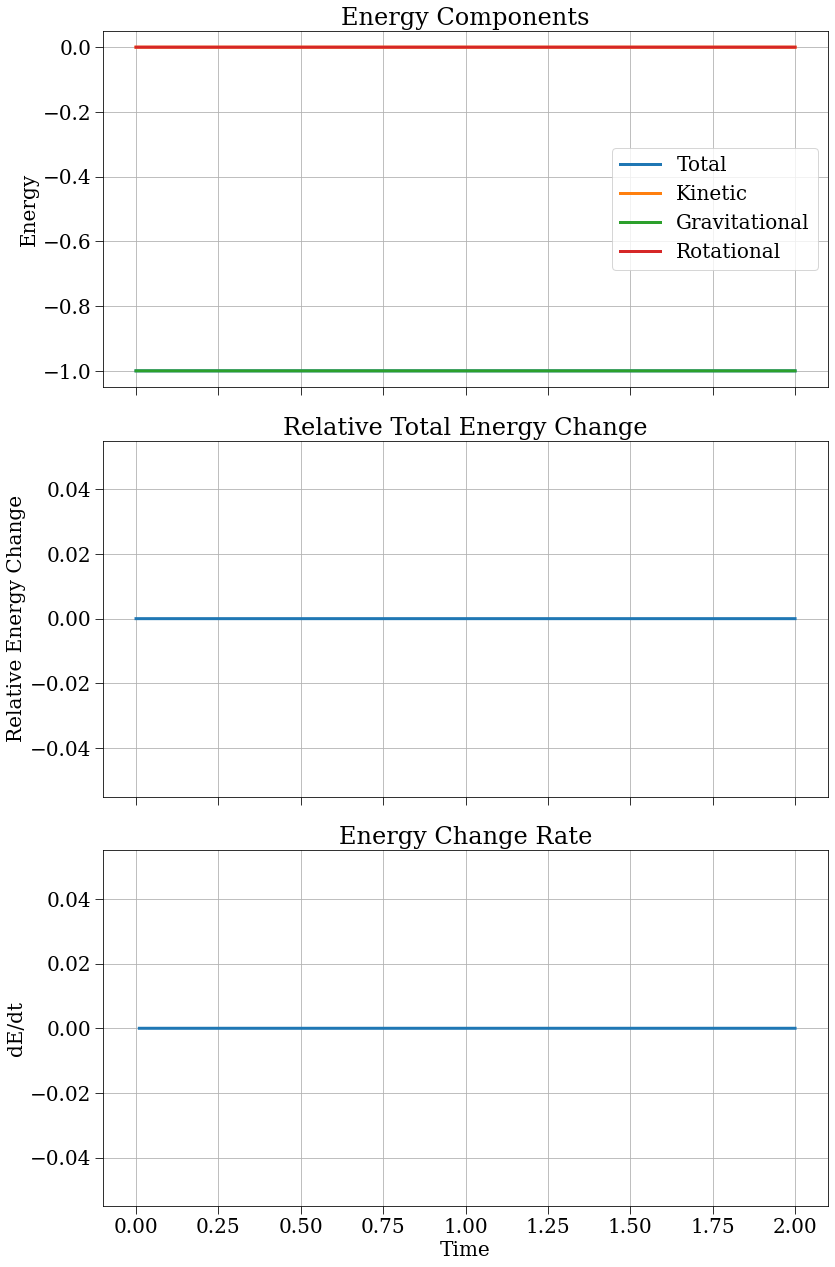

In [14]:
def analyze_energy_conservation(results):
    t = results['t']
    e_tot = np.sum(results['e_tot'], axis=1)
    e_k = np.sum(results['e_k'], axis=1)
    e_g = np.sum(results['e_g'], axis=1)
    e_r = np.sum(results['e_r'], axis=1)
    
    # Calculate relative energy change
    e_rel_change = (e_tot - e_tot[0]) / e_tot[0]
    
    # Calculate energy change per time step
    de_dt = np.diff(e_tot) / np.diff(t)
    
    # Plot results
    fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    
    axs[0].plot(t, e_tot, label='Total')
    axs[0].plot(t, e_k, label='Kinetic')
    axs[0].plot(t, e_g, label='Gravitational')
    axs[0].plot(t, e_r, label='Rotational')
    axs[0].set_ylabel('Energy')
    axs[0].legend()
    axs[0].set_title('Energy Components')
    
    axs[1].plot(t, e_rel_change)
    axs[1].set_ylabel('Relative Energy Change')
    axs[1].set_title('Relative Total Energy Change')
    
    axs[2].plot(t[1:], de_dt)
    axs[2].set_ylabel('dE/dt')
    axs[2].set_xlabel('Time')
    axs[2].set_title('Energy Change Rate')
    
    plt.tight_layout()
    
    
    # Identify largest energy changes
    largest_changes = np.argsort(np.abs(de_dt))[-5:]
    print("Time steps with largest energy changes:")
    for i in largest_changes:
        print(f"Time: {t[i+1]:.6f}, dE/dt: {de_dt[i]:.6e}")

# Use the function
analyze_energy_conservation(results)

[-0.90605472 -0.90605472 -0.90605472 ...  0.23936079  0.23936056
  0.23936033]
[-0.00000000e+00 -1.65196233e-10 -6.61451761e-10 ... -1.26417917e+00
 -1.26417892e+00 -1.26417867e+00]
98.66836739073183
36643
[-0.90605472 -0.90605471 -0.90605466 ...  0.23974233  0.23974002
  0.23973776]
[-0.00000000e+00 -1.40480562e-08 -6.28726174e-08 ... -1.26460028e+00
 -1.26459773e+00 -1.26459524e+00]
98.6693562015964
8580
[-0.90605472 -0.90605472 -0.90605472 ...  0.2393581   0.23935807
  0.23935805]
[-0.00000000e+00 -1.65445099e-12 -6.61841664e-12 ... -1.26417620e+00
 -1.26417618e+00 -1.26417615e+00]
98.66835967217149
148072
[-0.90620467 -0.90620467 -0.90620467 ... 14.46699328 14.46699328
 14.46699328]
[-0.00000000e+00  2.33143183e-13  2.66589367e-13 ... -1.69643773e+01
 -1.69643773e+01 -1.69643773e+01]
9521.2616222328
22618


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

[-0.89145691 -0.8914569  -0.89145686 ... -0.84020782 -0.84022631
 -0.84024481]
[-0.00000000e+00 -1.59447011e-08 -6.37795981e-08 ... -5.74891455e-02
 -5.74683977e-02 -5.74476524e-02]
9.48884348534203
133104


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

[-0.90609957 -0.90609957 -0.90609957 ...  0.24716815  0.24716792
  0.24716769]
[-0.00000000e+00 -1.65204719e-10 -6.61483590e-10 ... -1.27278254e+00
 -1.27278229e+00 -1.27278204e+00]
98.63917435204691
36557


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

[-0.90156928 -0.90156928 -0.90156928 ... -0.03778889 -0.03778917
 -0.03778945]
[-0.00000000e+00 -1.64380425e-10 -6.58169558e-10 ... -9.58085425e-01
 -9.58085116e-01 -9.58084809e-01]
101.60238060893182
47077


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

[-0.90605472 -0.90605472 -0.90605472 ... -0.56648525 -0.56648499
 -0.56648473]
[-0.00000000e+00 -1.65196233e-10 -6.61451761e-10 ... -3.74778101e-01
 -3.74778386e-01 -3.74778672e-01]
94.39140068814791
39154


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

[-0.90605472 -0.90605472 -0.90605472 ... -0.87176914 -0.87176739
 -0.87176564]
[-0.00000000e+00 -1.65196233e-10 -6.61451761e-10 ... -3.78405202e-02
 -3.78424457e-02 -3.78443791e-02]
93.81742770828272
43434


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

[-0.90605472 -0.90605472 -0.90605472 ... -1.36031254 -1.36031436
 -1.36031605]
[-0.00000000e+00 -1.65196233e-10 -6.61451761e-10 ...  5.01358040e-01
  5.01360057e-01  5.01361919e-01]
91.46283265789208
82608


/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jsipple/.conda/envs/jsipple/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

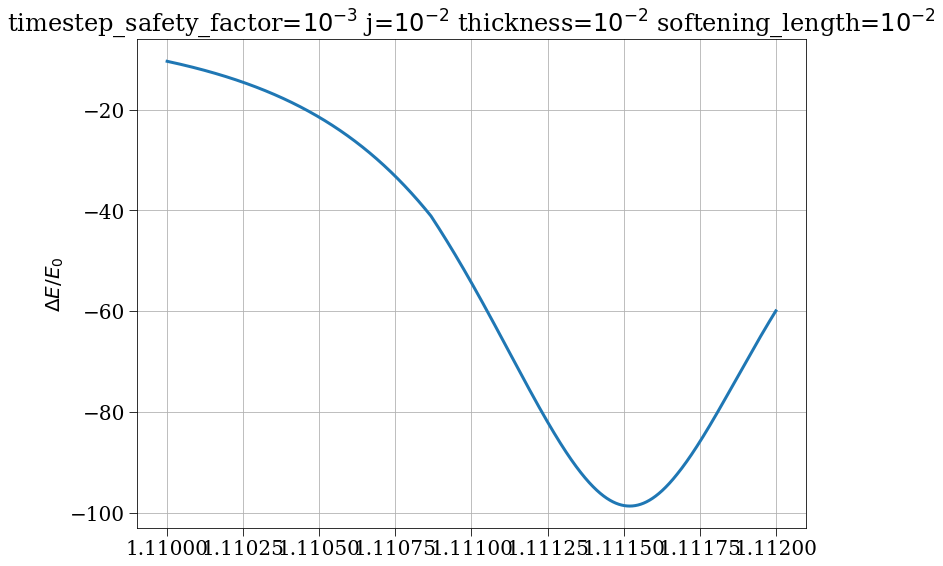

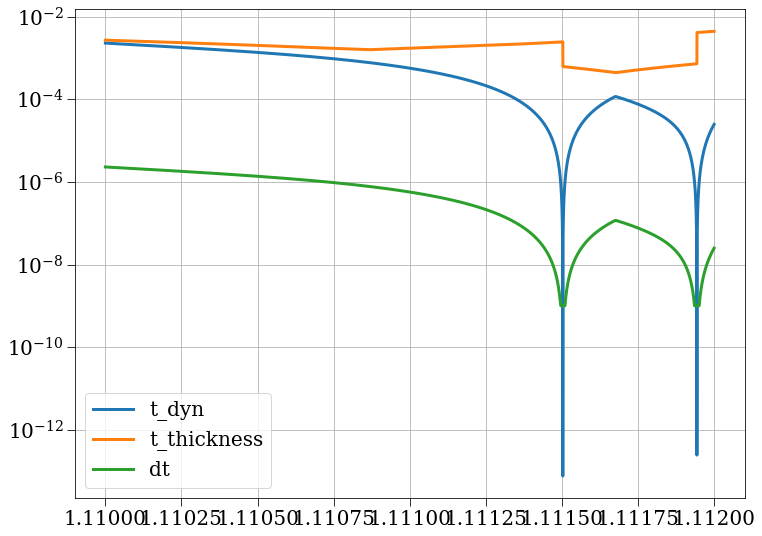

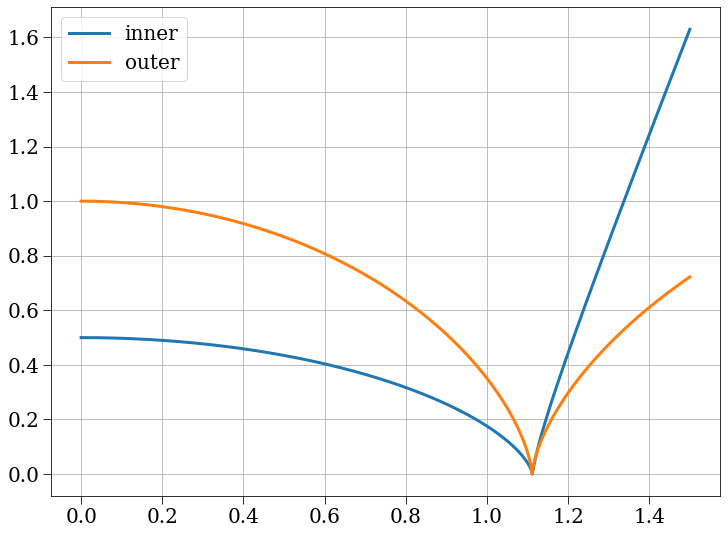

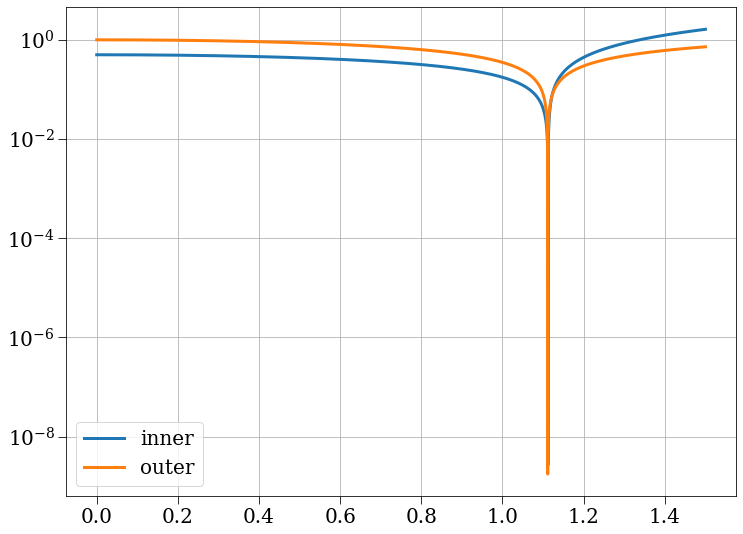

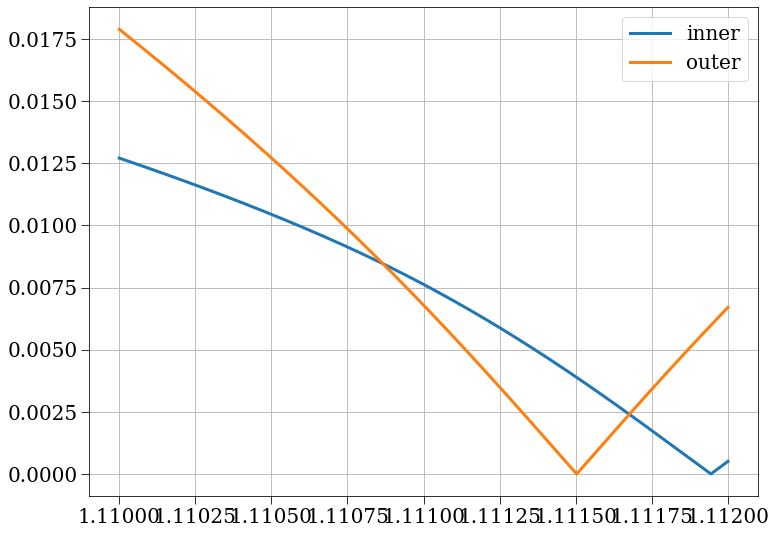

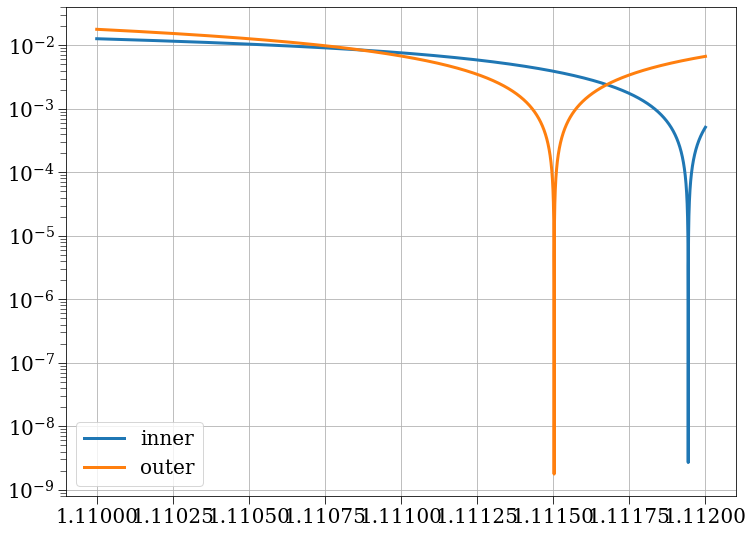

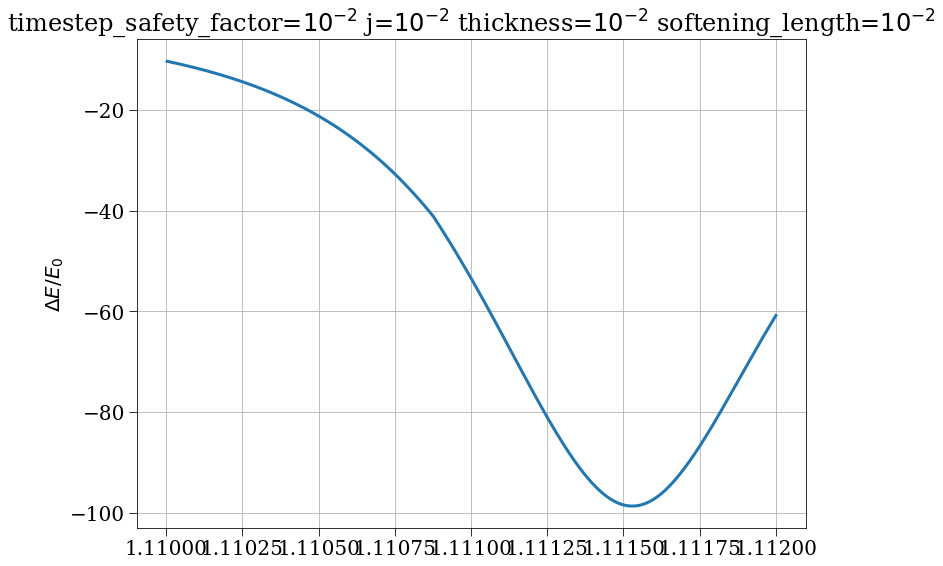

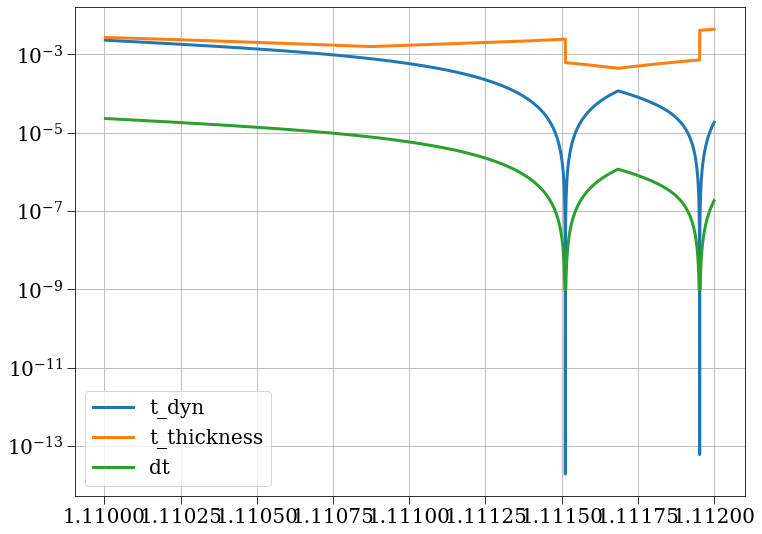

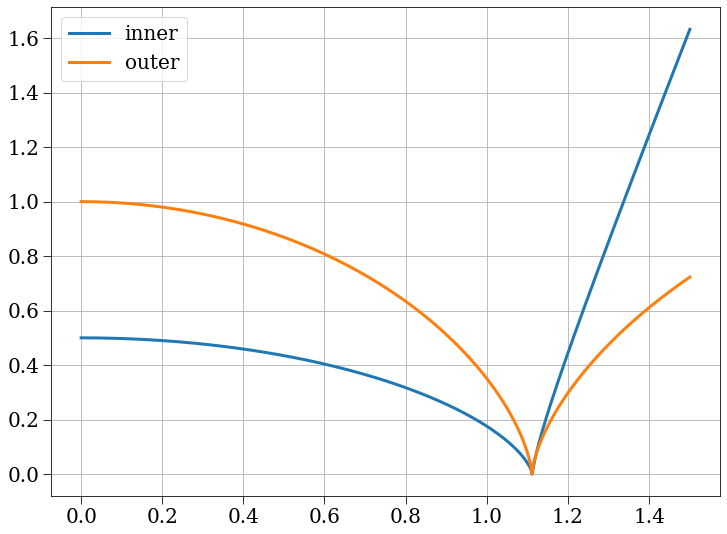

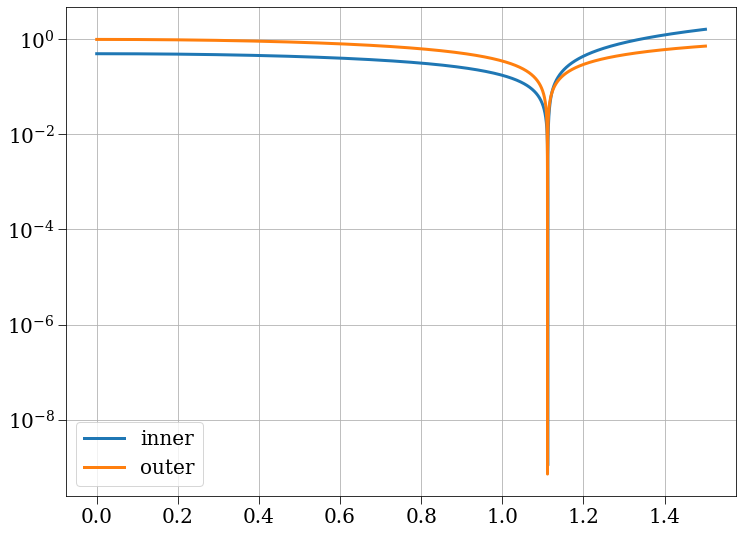

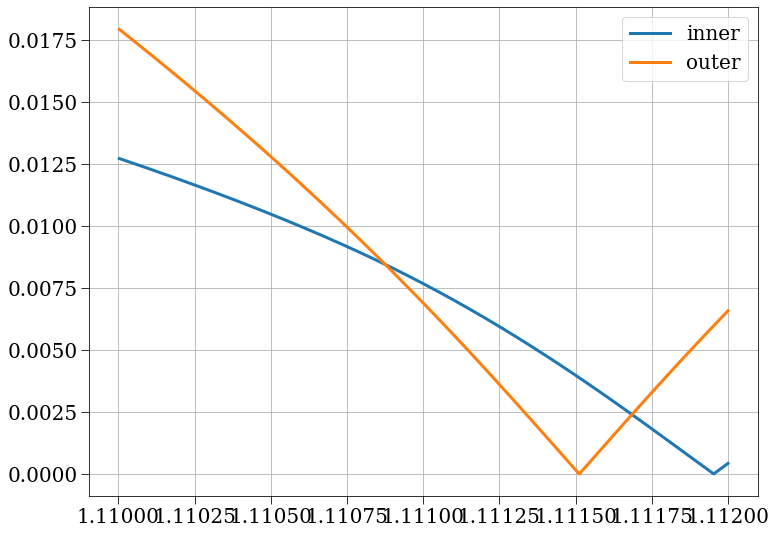

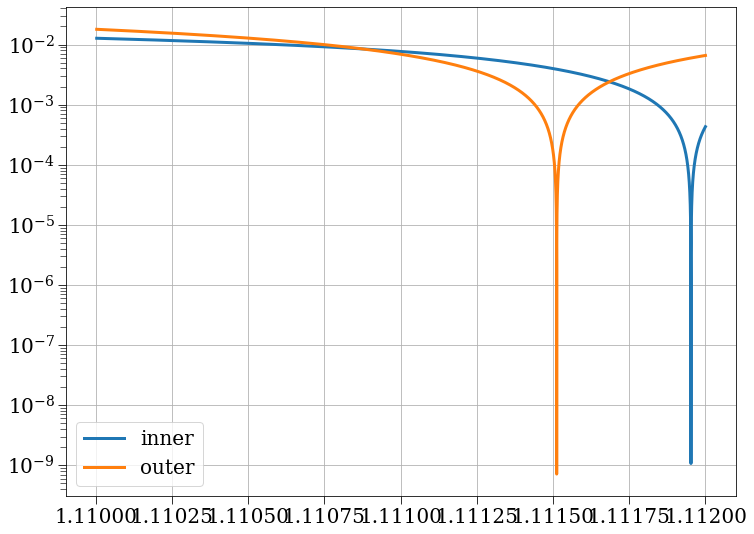

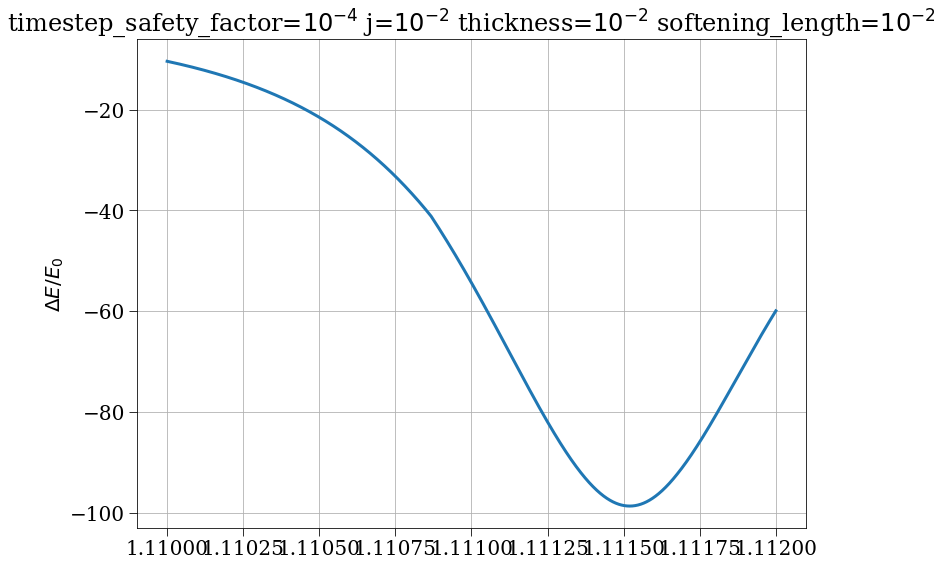

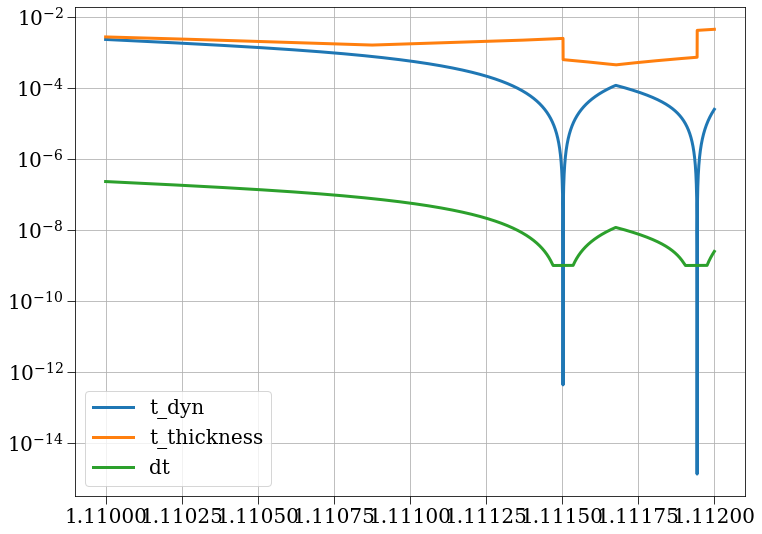

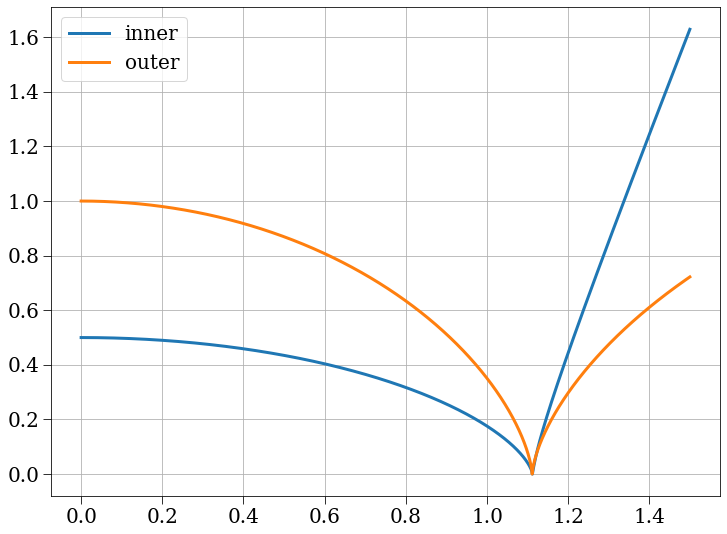

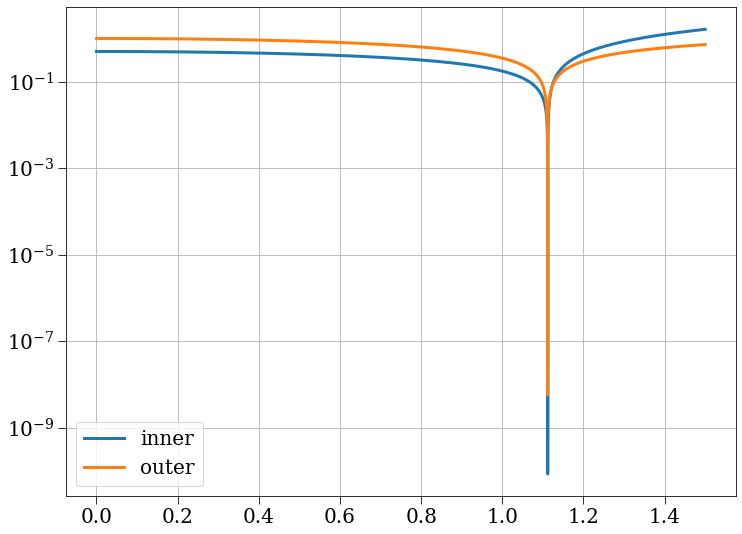

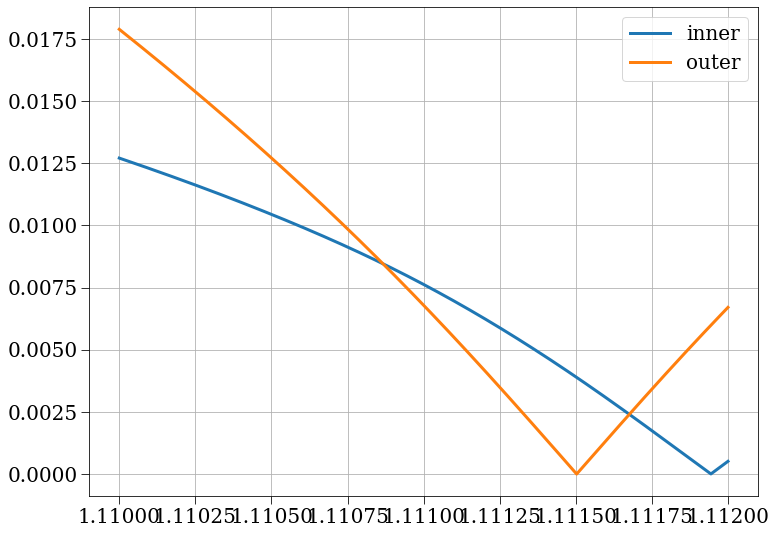

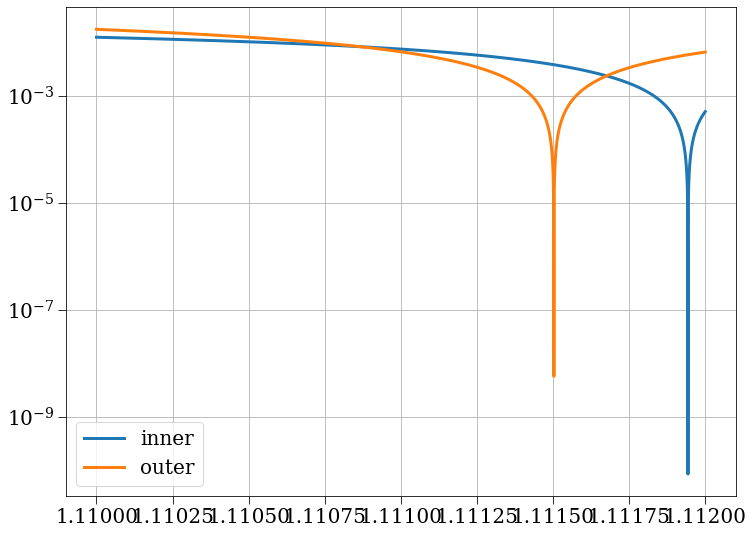

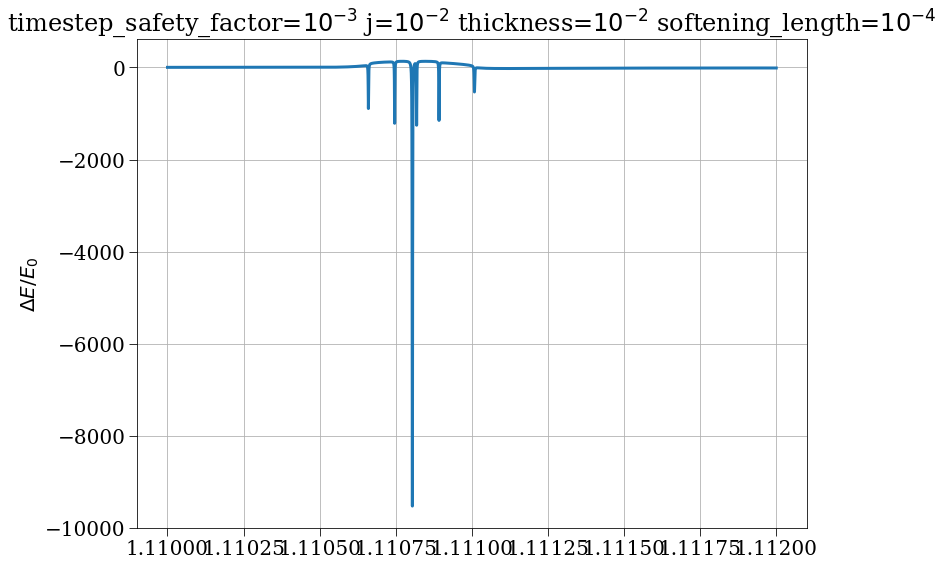

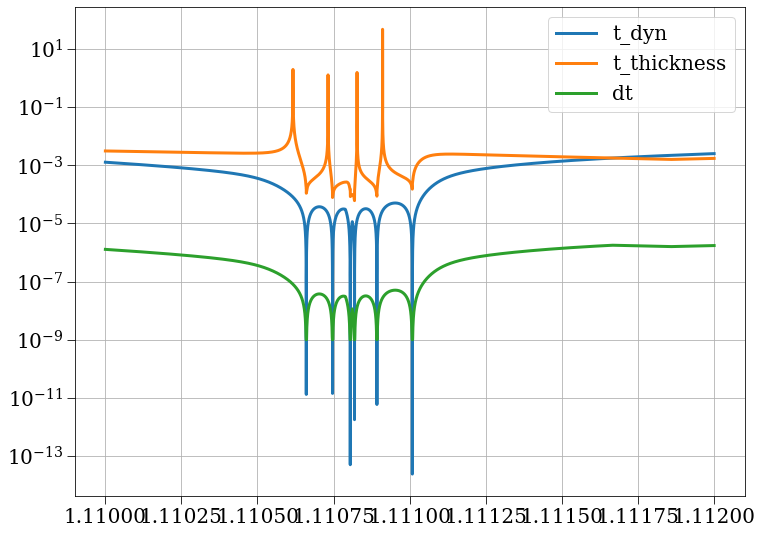

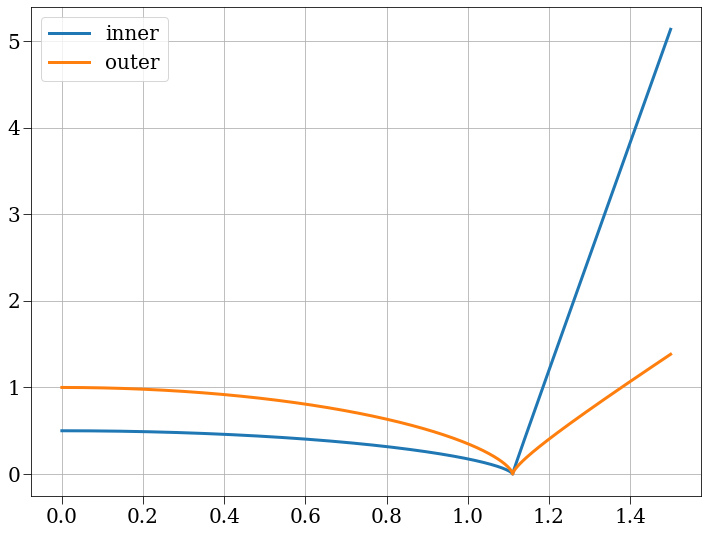

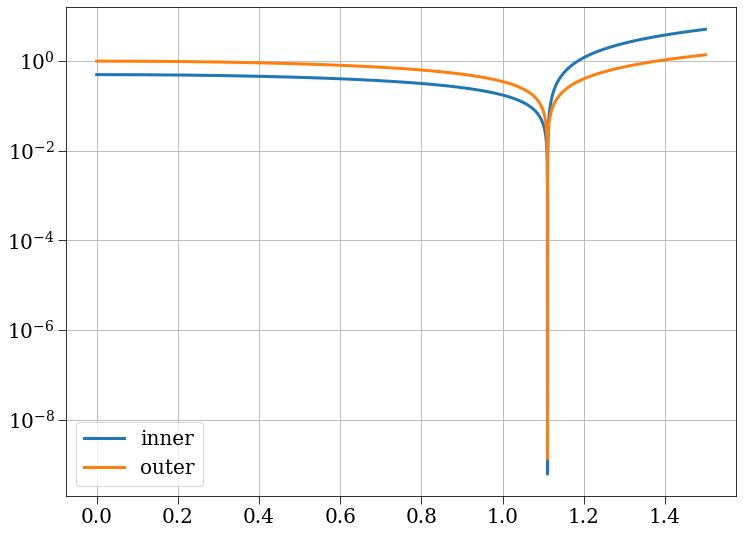

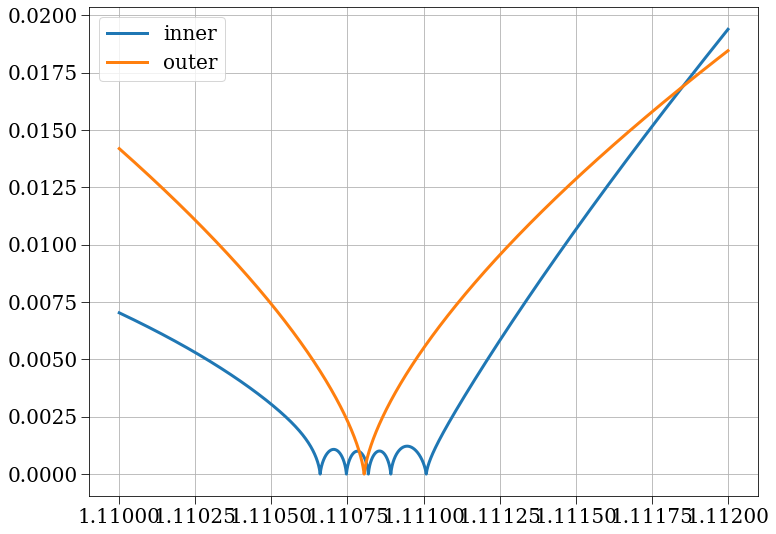

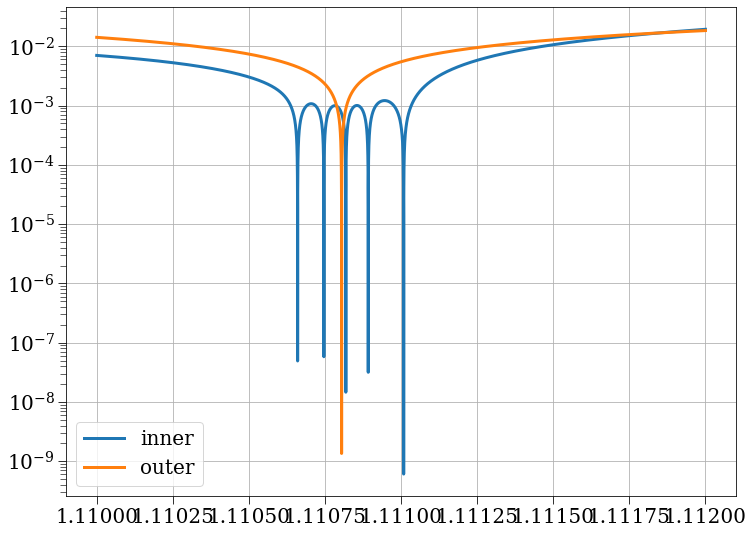

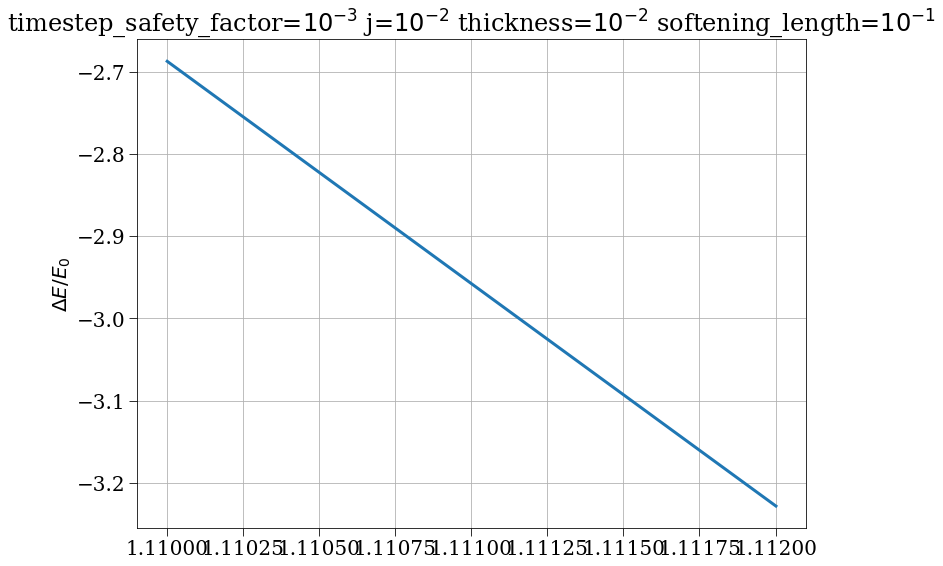

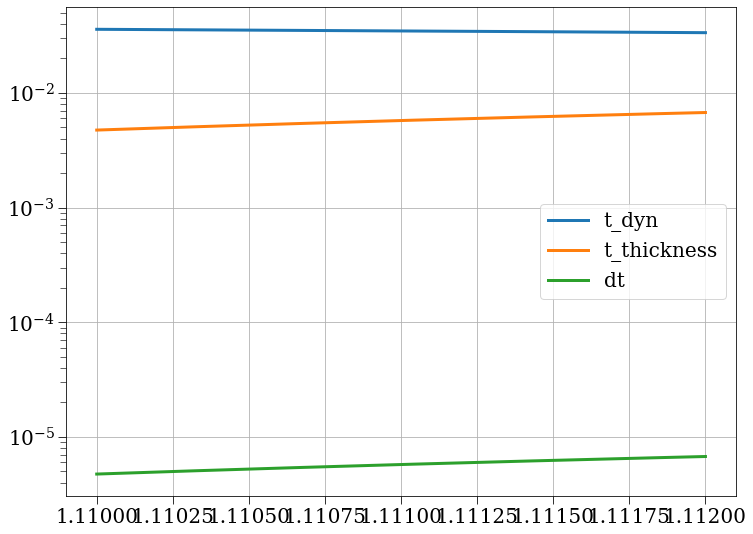

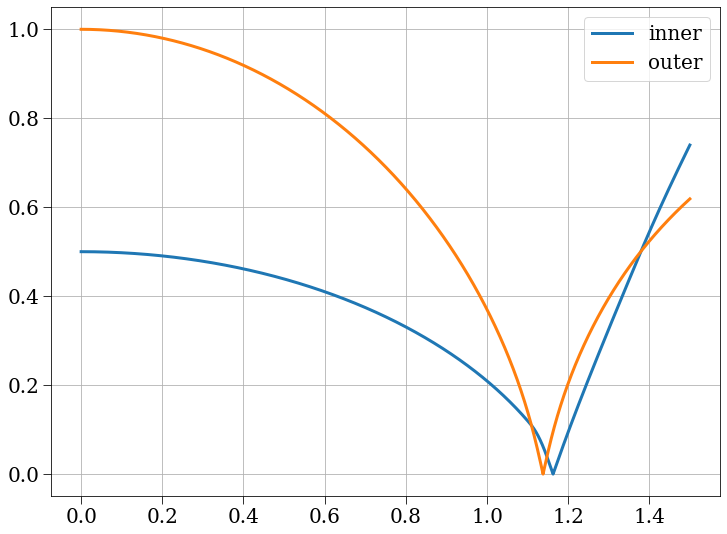

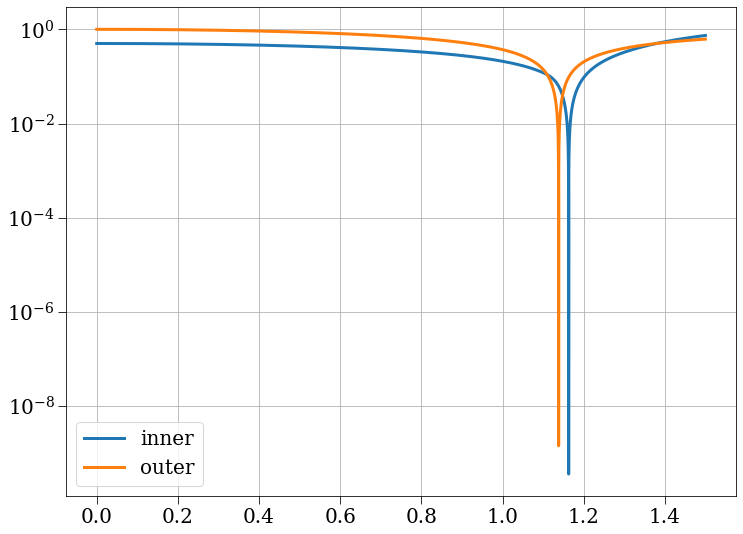

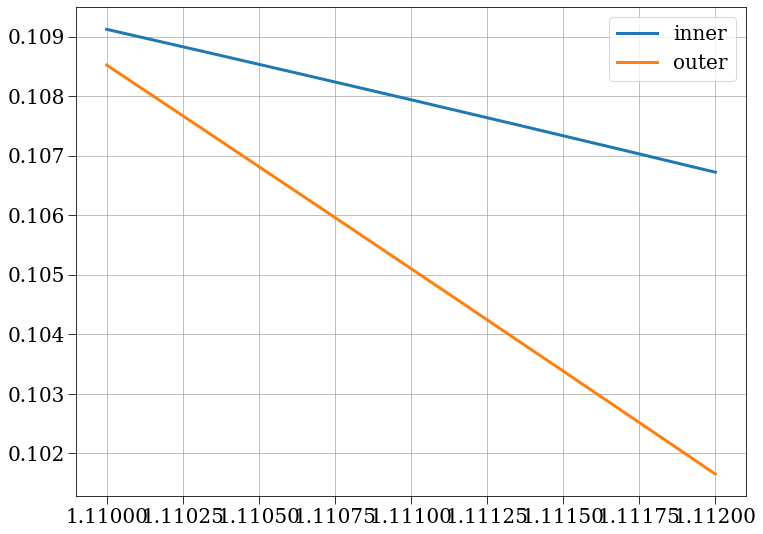

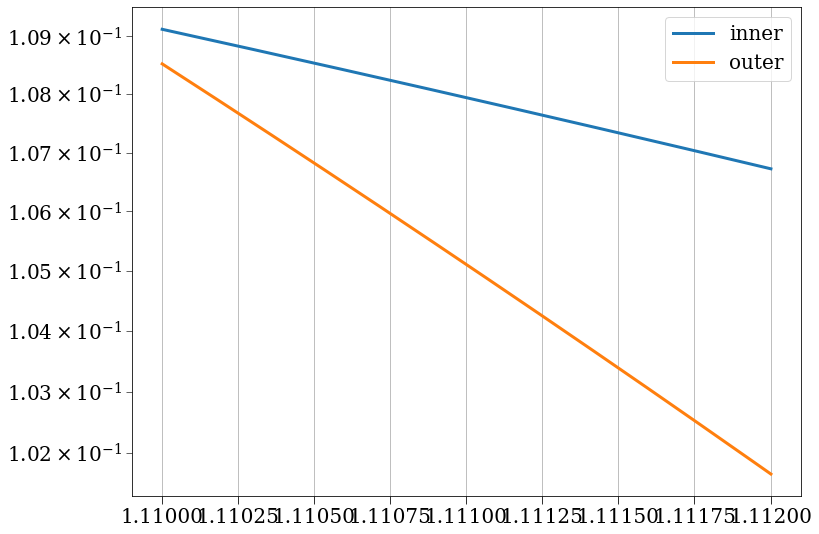

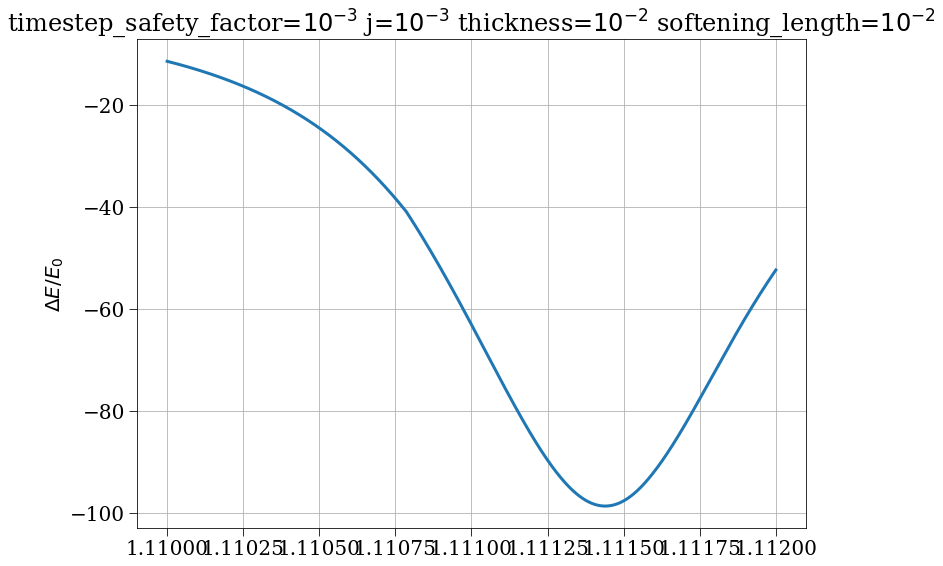

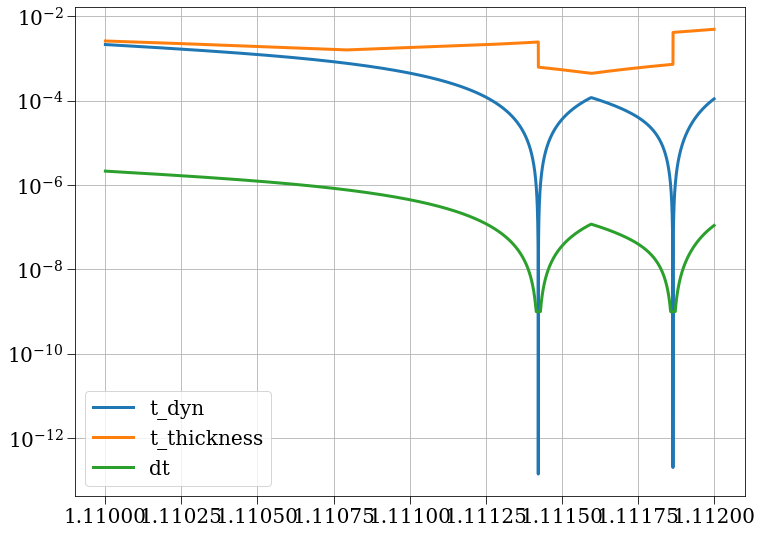

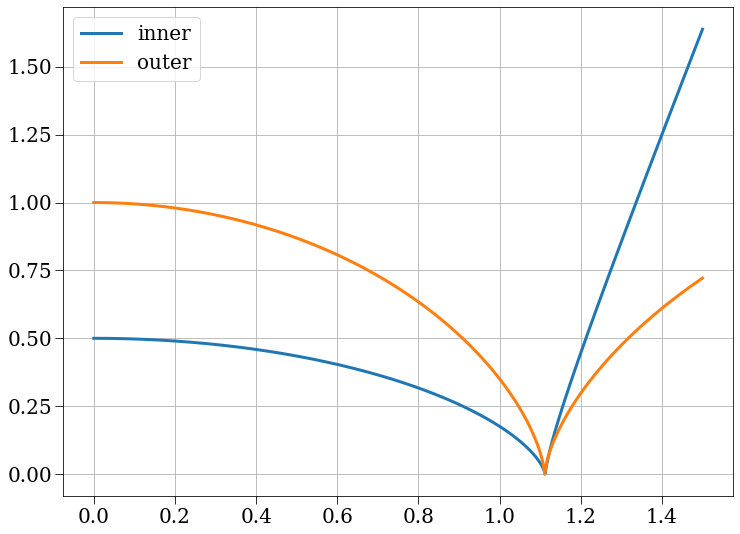

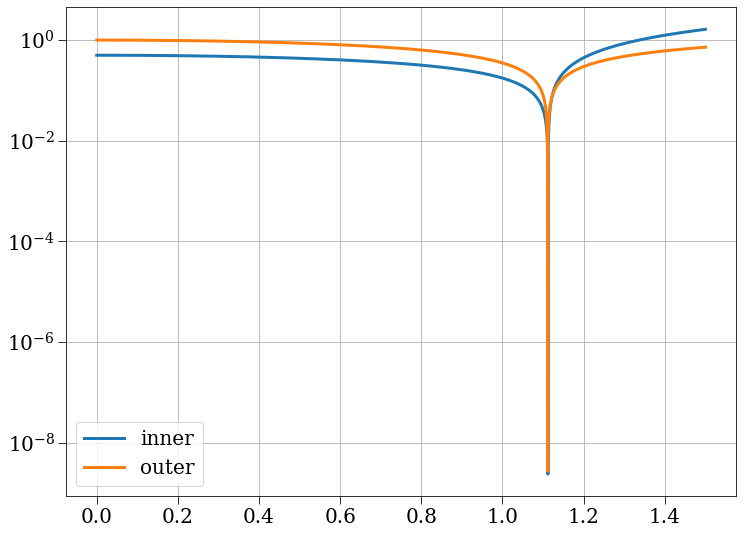

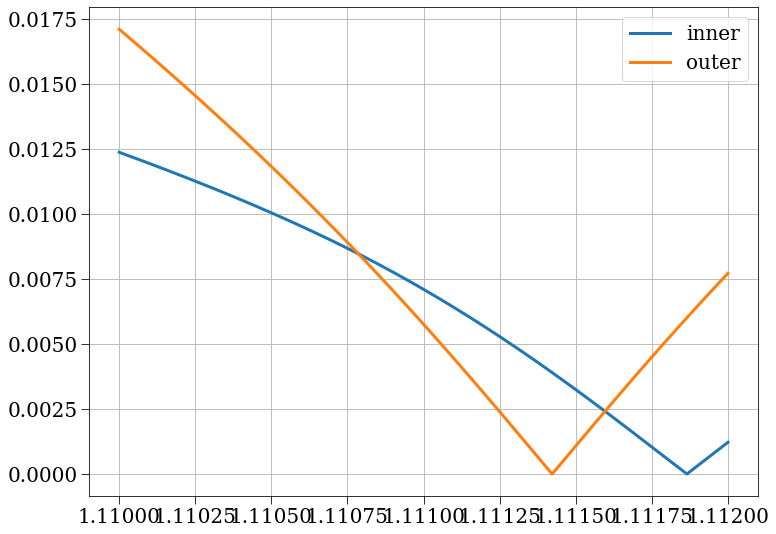

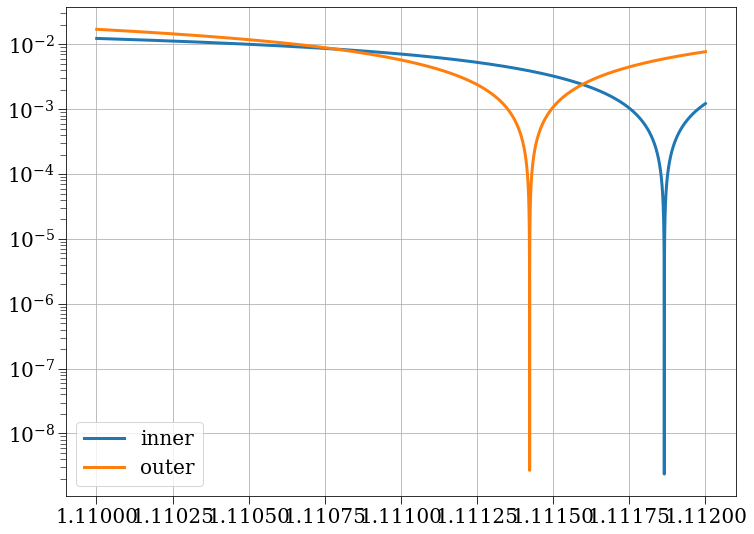

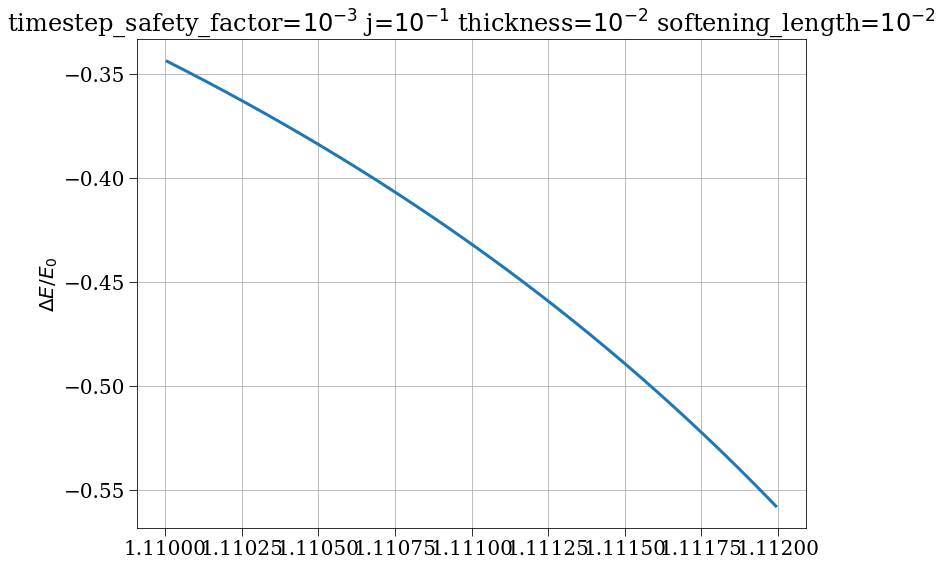

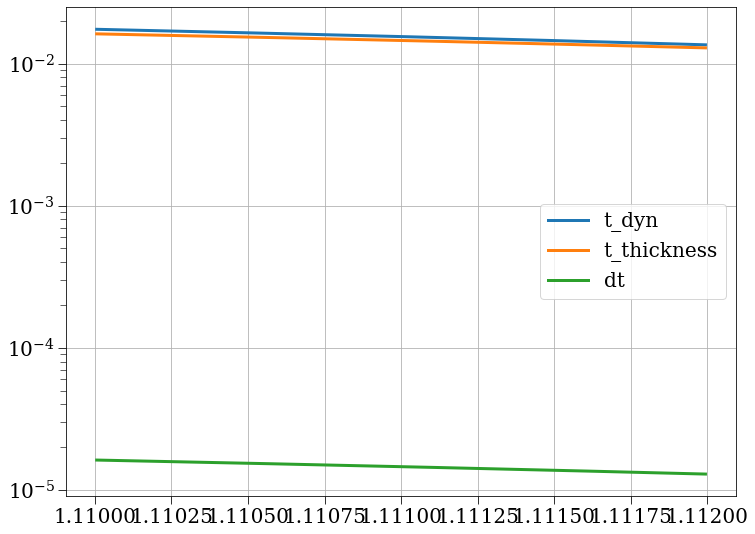

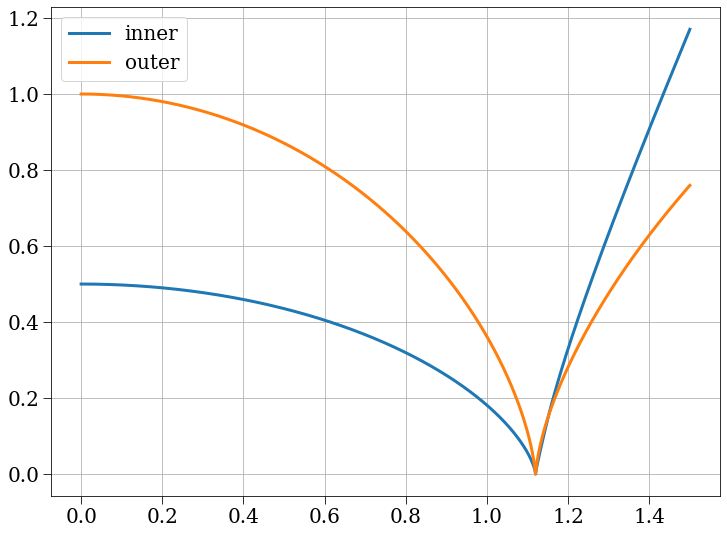

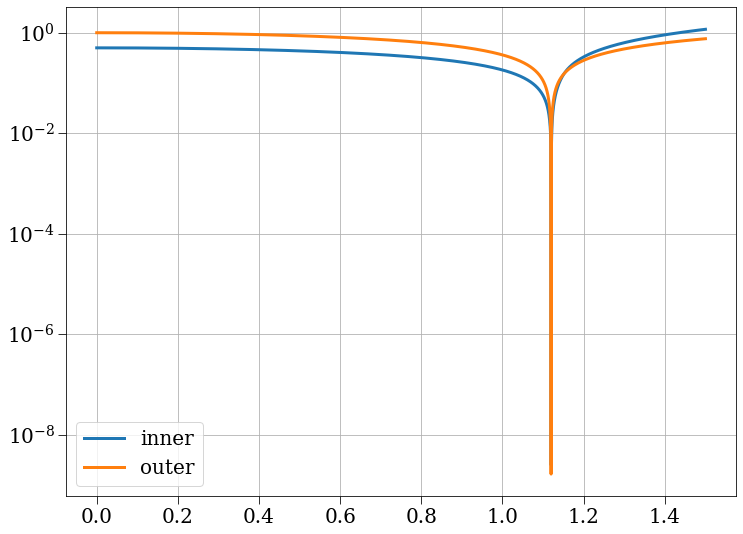

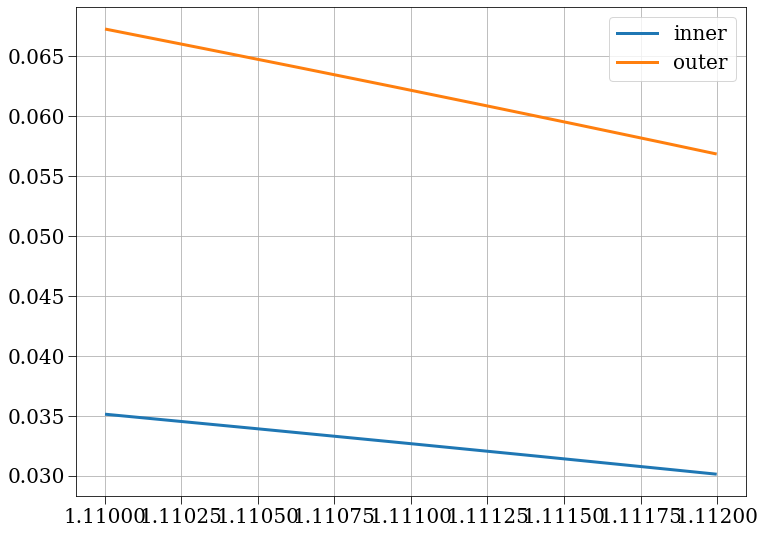

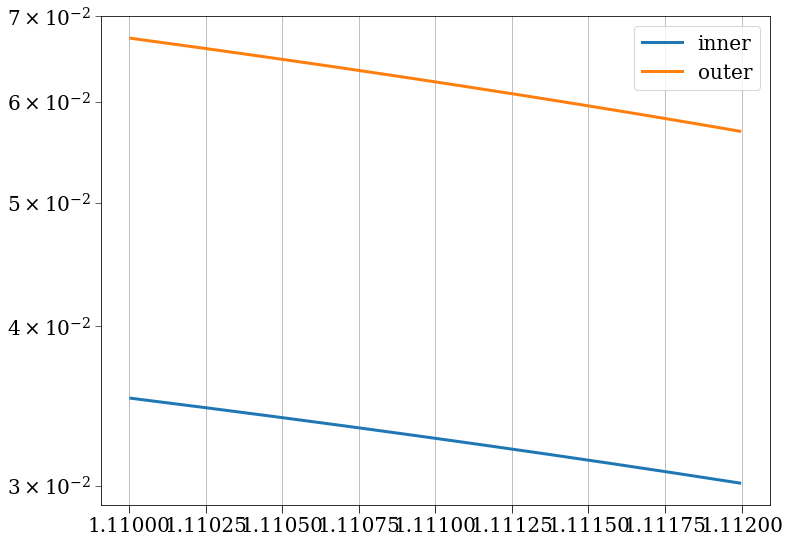

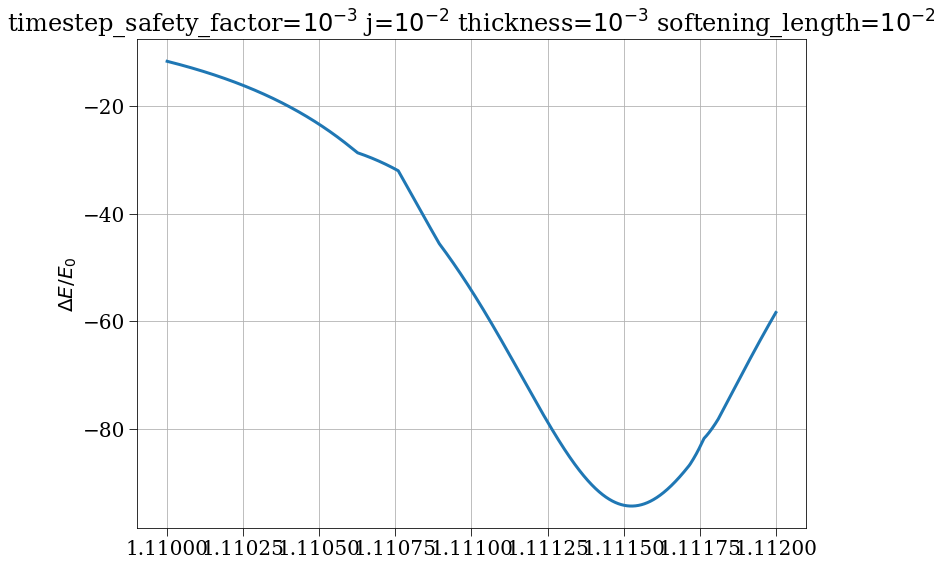

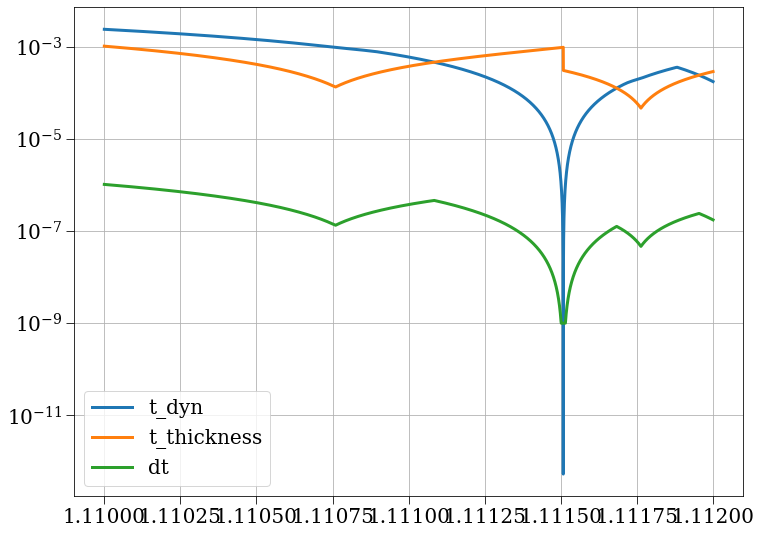

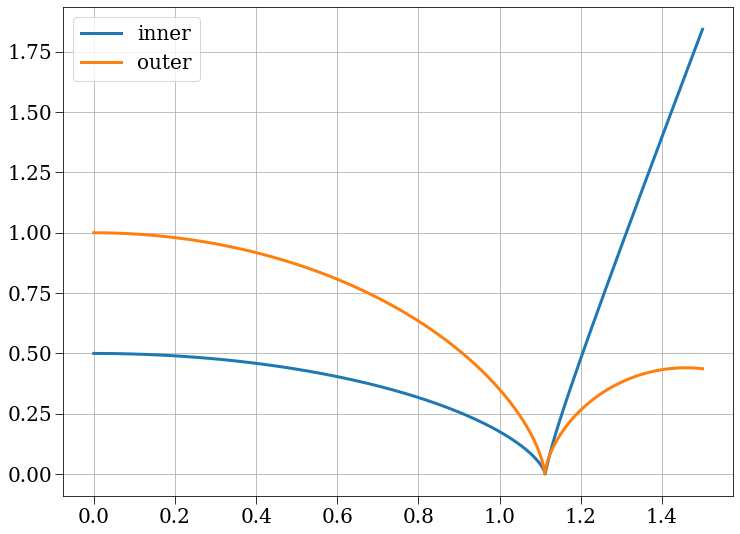

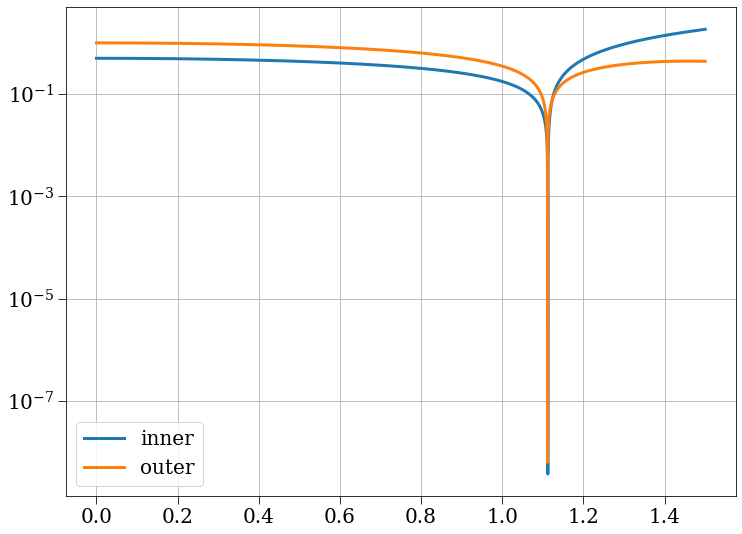

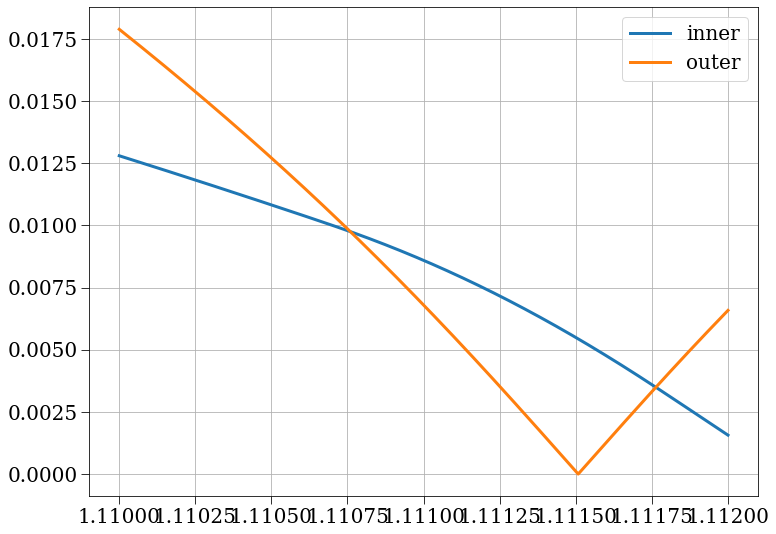

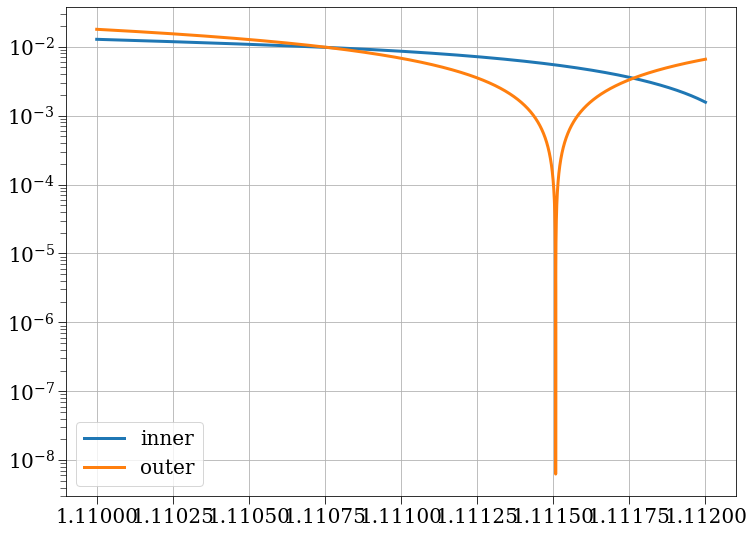

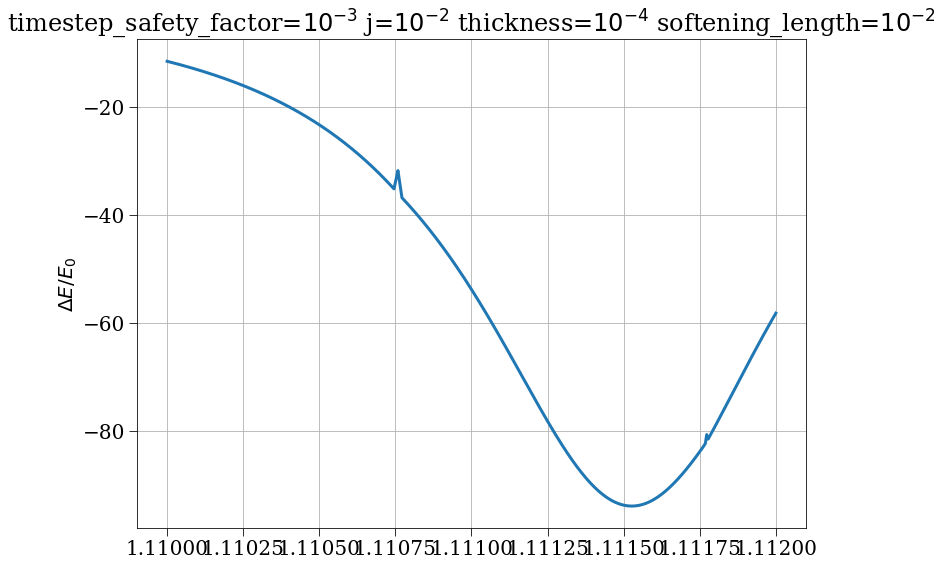

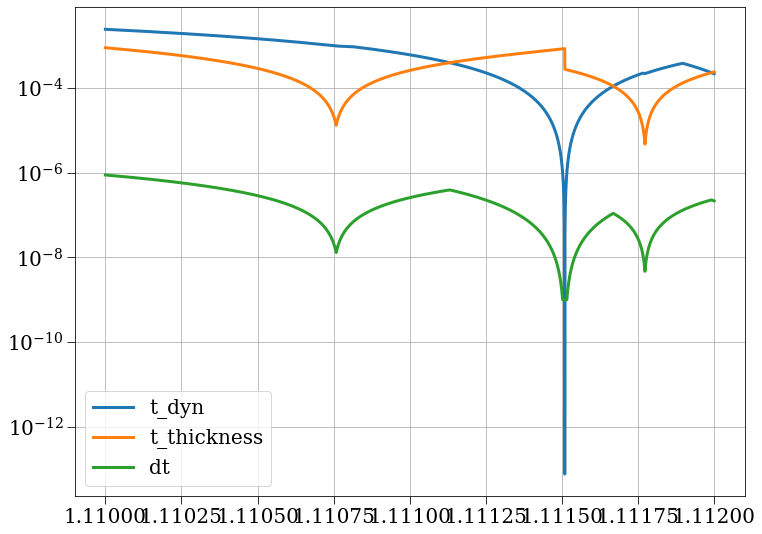

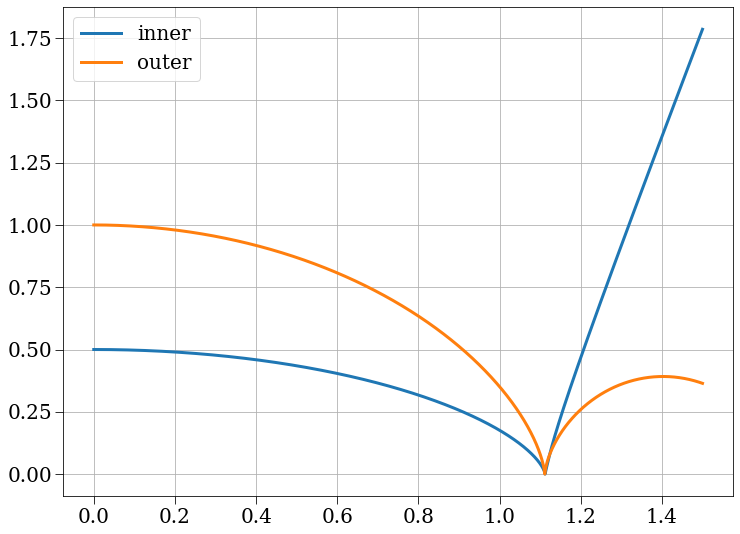

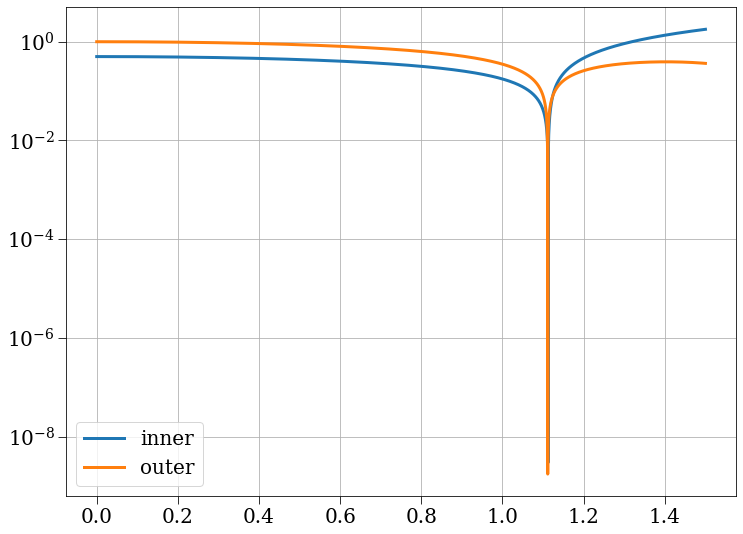

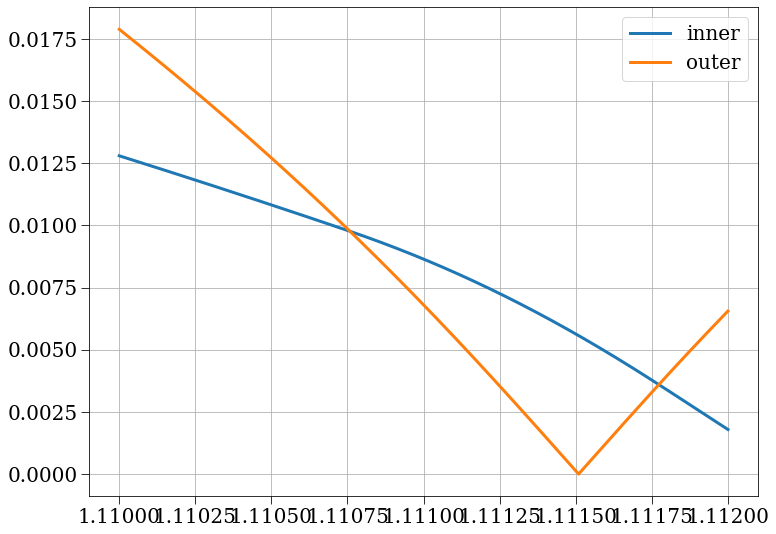

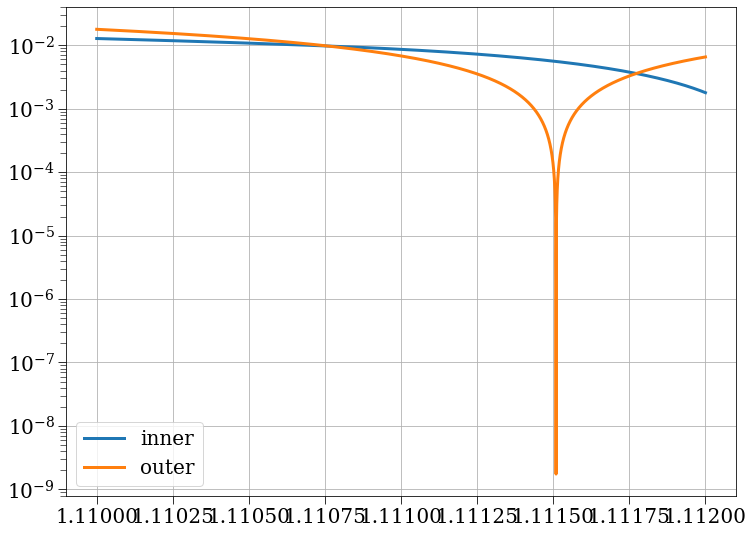

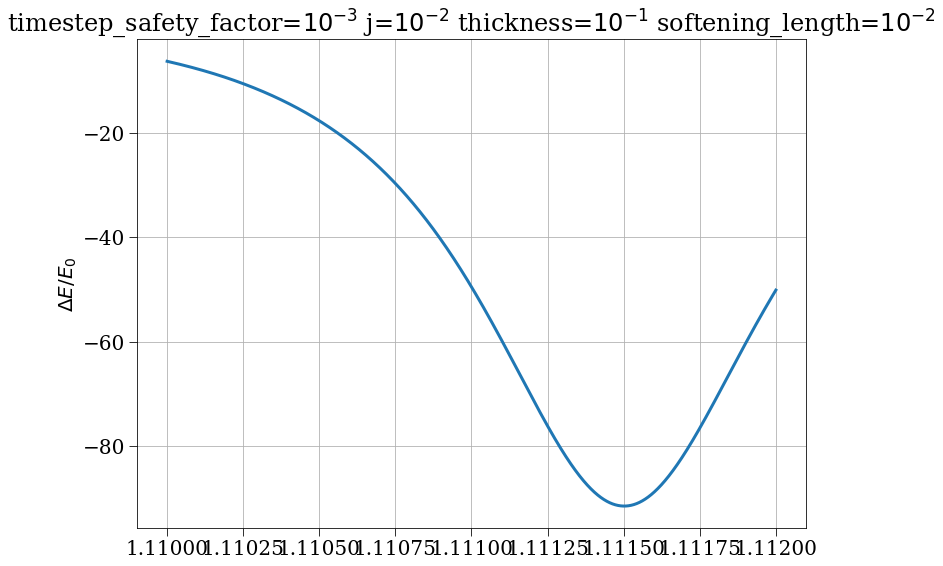

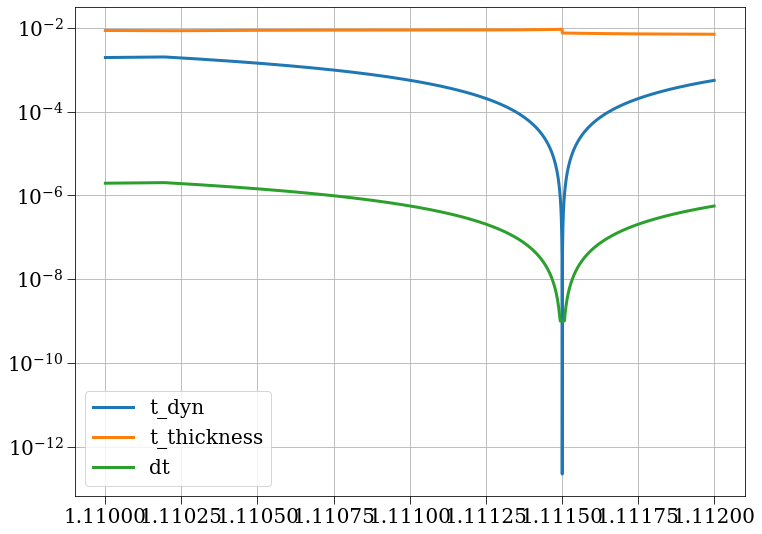

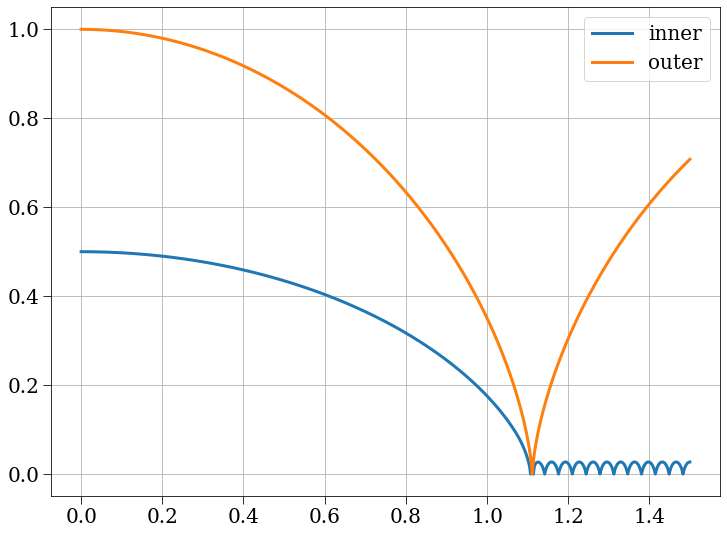

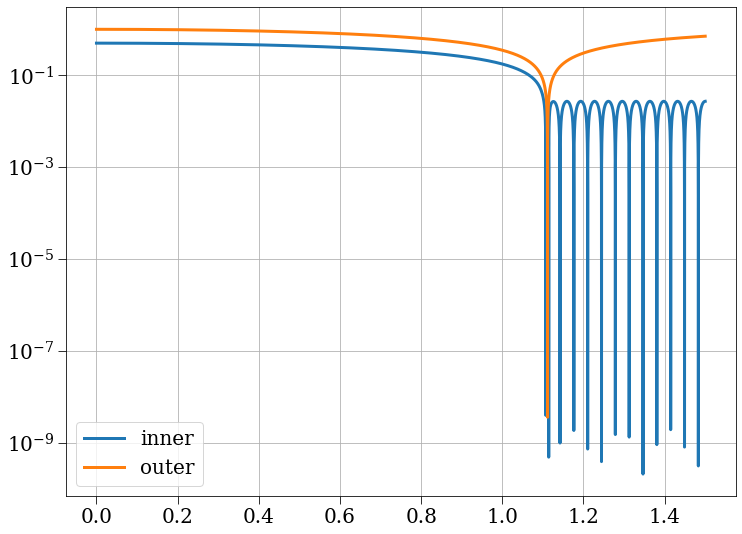

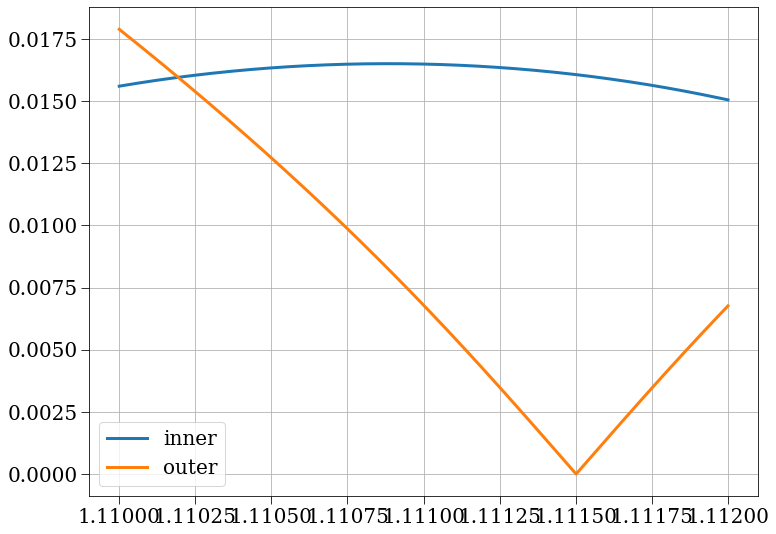

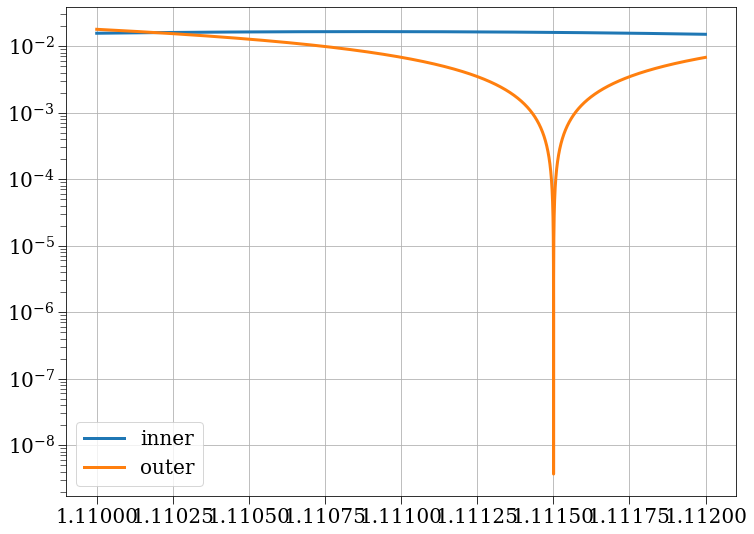

In [4]:
from utils import load_simulation_data

# Assuming all the plotting functions are already defined in this notebook

def process_results(results, sim_name):
    print(sim_name)
    #plot_timescales(results)
    shells = None  # [0,24,49,74,99]
    plot_shell_property(results, 'r', ylim=[-0.1, 2], shell_indices=shells, title=sim_name)
    plot_shell_property(results, 'r', yscale='log', limit_axis=False, shell_indices=shells)
    plot_total_energy_relative_change(results, limit_axis=False, yscale='linear')
    plot_total_energy_relative_change(results, limit_axis=False, yscale='log', ylim=[1e-5, None])
    #plot_shell_property(results, 'm_enc', limit_axis=False, shell_indices=shells)
    #plot_shell_property(results, 'v', limit_axis=False, shell_indices=shells)
    #plot_shell_property(results, 'a', limit_axis=False, shell_indices=shells)
    #plot_energy_components(results, shell_index=0, limit_axis=False)
    #plot_energy_components(results, shell_index=-1, limit_axis=False)
    #analyze_energy_conservation(results)

def analyze_results(results, sim_name):
    total_energy_sum = np.sum(results['e_tot'], axis=1)
    print(total_energy_sum)
    reldif = (total_energy_sum - total_energy_sum[0]) / total_energy_sum[0]
    print(reldif)
    print(max(np.abs(reldif)))
    amax = np.argmax(np.abs(reldif))
    print(amax)
    t_zoom = 1.111
    amax = np.argmin(np.abs(results['t'] - t_zoom))

    # print(results['t'][amax])
    # around = int(1e5)
    # start_idx = max(0, amax-around)
    # end_idx = min(amax+around, len(results['t'])-1)

    # Option to set start_idx and end_idx based on tzmin and tzmax
    deltzoom = 1e-3
    tzmin = t_zoom - deltzoom  # Adjust this value as needed
    tzmax = t_zoom + deltzoom  # Adjust this value as needed

    # Find the indices where results['t'] is closest to tzmin and tzmax
    start_idx = np.argmin(np.abs(results['t'] - tzmin))
    end_idx = np.argmin(np.abs(results['t'] - tzmax))

    # Ensure that start_idx is before end_idx
    if start_idx > end_idx:
        start_idx, end_idx = end_idx, start_idx

    # Add 1 to end_idx to include the last point when slicing
    end_idx += 1

    plt.figure()
    plt.plot(results['t'][start_idx:end_idx], reldif[start_idx:end_idx])
    plt.ylabel(r'$\Delta E/E_0$')
    plt.title(sim_name)
    plt.figure()
    plt.plot(results['t'][start_idx:end_idx], results['t_dyn'][start_idx:end_idx], label='t_dyn')
    plt.plot(results['t'][start_idx:end_idx], results['t_thickness'][start_idx:end_idx], label='t_thickness')
    plt.plot(results['t'][start_idx:end_idx], results['dt'][start_idx:end_idx], label='dt')
    plt.yscale('log')
    plt.legend()
    plt.figure()
    plt.plot(results['t'], results['r'][:, 0], label='inner')
    plt.plot(results['t'], results['r'][:, -1], label='outer')
    plt.legend()
    plt.figure()
    plt.plot(results['t'], results['r'][:, 0], label='inner')
    plt.plot(results['t'], results['r'][:, -1], label='outer')
    plt.yscale('log')
    plt.legend()
    plt.figure()
    plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, 0], label='inner')
    plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, -1], label='outer')
    plt.legend()
    plt.figure()
    plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, 0], label='inner')
    plt.plot(results['t'][start_idx:end_idx], results['r'][start_idx:end_idx, -1], label='outer')
    plt.yscale('log')
    plt.legend()

# Process all .h5 files in the src/ directory and its subdirectories
src_dir = '/home/jsipple/one_d_spherical_collapse/one-d-spherical-collapse-of-fuzzy-dark-matter/src/runs'
for root, dirs, files in os.walk(src_dir):
    for file in files:
        if file.endswith('.h5'):
            file_path = os.path.join(root, file)
            # Load the simulation data
            try:
                params, results = load_simulation_data(file_path)
                # Parse the sim name from the file name
                sf = params['safety_factor']
                jc = params['j_coef']
                tc = params['thickness_coef']
                soft = params['softlen']
                sim_name = fr'timestep_safety_factor=$10^{{{np.log10(sf):.0f}}}$ j=$10^{{{np.log10(jc):.0f}}}$ thickness=$10^{{{np.log10(tc):.0f}}}$ softening_length=$10^{{{np.log10(soft):.0f}}}$'
                # Process and display results
                analyze_results(results, sim_name)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cycloid_solution(t, A):
    """
    Compute the cycloid solution for spherical collapse.
    
    Parameters:
    t : array-like
        Time values
    A : float
        Amplitude parameter
    
    Returns:
    r : array-like
        Radial positions
    v : array-like
        Velocities
    """
    theta = np.sqrt(np.float128(8) * np.pi / np.float128(A)) * np.float128(t)
    r = np.float128(0.5) * np.float128(A) * (np.float128(1) + np.cos(theta))
    v = -np.float128(0.5) * np.float128(A) * np.sqrt(np.float128(8) * np.pi / np.float128(A)) * np.sin(theta)
    return r, v

def compute_energies(r, v, m, G):
    """
    Compute kinetic, potential, and total energy.
    
    Parameters:
    r : array-like
        Radial positions
    v : array-like
        Velocities
    m : float
        Mass of the particle
    G : float
        Gravitational constant
    
    Returns:
    E_k : array-like
        Kinetic energy
    E_p : array-like
        Potential energy
    E_tot : array-like
        Total energy
    """
    E_k = np.float128(0.5) * np.float128(m) * v**2
    E_p = -np.float128(G) * np.float128(m)**2 / r
    E_tot = E_k + E_p
    return E_k, E_p, E_tot

# Set up parameters
G = np.float128(1.0)  # Gravitational constant
m = np.float128(1.0)  # Mass of the particle
A = np.float128(1.0)  # Amplitude parameter
t_max = np.float128(2) * np.pi * np.sqrt(np.float128(A) / (np.float128(8) * np.pi))  # One full cycle
t = np.linspace(np.float128(0), t_max, 1000, dtype=np.float128)

# Compute cycloid solution
r, v = cycloid_solution(t, A)

# Compute energies
E_k, E_p, E_tot = compute_energies(r, v, m, G)

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(t, r, label='r(t)')
plt.plot(t, v, label='v(t)')
plt.xlabel('Time')
plt.ylabel('r, v')
plt.legend()
plt.title('Cycloid Solution')

plt.subplot(212)
plt.plot(t, np.abs(E_k), label='Kinetic Energy')
plt.plot(t, np.abs(E_p), label='Potential Energy')
plt.plot(t, np.abs(E_tot), label='Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.yscale('log')
plt.ylim(1e0, 1e3)
plt.legend()
plt.title('Energy Conservation')

plt.tight_layout()


# Print energy conservation statistics
E_tot_initial = E_tot[0]
E_tot_relative_error = (E_tot - E_tot_initial) / E_tot_initial
print(f"Maximum relative error in total energy: {np.max(np.abs(E_tot_relative_error)):.2e}")
print(f"Standard deviation of relative error in total energy: {np.std(E_tot_relative_error):.2e}")

In [ ]:
# Define the gravitational acceleration function
def gravitational_acceleration(r, G, M):
    return -G * M / r**2

# Velocity Verlet integrator with reflecting sphere
def velocity_verlet(r0, v0, dt, steps, G, M, r_min):
    r, v = np.zeros(steps), np.zeros(steps)
    r[0], v[0] = r0, v0
    
    for i in range(1, steps):
        a = gravitational_acceleration(r[i-1], G, M)
        r[i] = r[i-1] + v[i-1]*dt + 0.5*a*dt**2
        
        # Reflect off the sphere at r_min
        if r[i] < r_min:
            r[i] = 2*r_min - r[i]
            v[i-1] = -v[i-1]  # Reverse velocity for elastic collision
        
        a_next = gravitational_acceleration(r[i], G, M)
        v[i] = v[i-1] + 0.5*(a + a_next)*dt
    
    return r, v

# Beeman integrator with reflecting sphere
def beeman(r0, v0, dt, steps, G, M, r_min):
    r, v = np.zeros(steps), np.zeros(steps)
    r[0], v[0] = r0, v0
    a_prev = gravitational_acceleration(r0, G, M)
    a = a_prev
    
    for i in range(1, steps):
        r[i] = r[i-1] + v[i-1]*dt + (4*a - a_prev)*dt**2/6
        
        # Reflect off the sphere at r_min
        if r[i] < r_min:
            r[i] = 2*r_min - r[i]
            v[i-1] = -v[i-1]  # Reverse velocity for elastic collision
        
        a_next = gravitational_acceleration(r[i], G, M)
        v[i] = v[i-1] + (2*a_next + 5*a - a_prev)*dt/6
        a_prev, a = a, a_next
    
    return r, v

# Set up parameters for the test
G = 1.0
M = 1.0
r0 = 1.0
v0 = 0.5
dt = 0.0001
steps = 100000  # Increased number of steps to see multiple bounces
r_min = 0.1  # Radius of the reflecting sphere
t = np.arange(steps) * dt

# Run simulations
r_vv, v_vv = velocity_verlet(r0, v0, dt, steps, G, M, r_min)
r_beeman, v_beeman = beeman(r0, v0, dt, steps, G, M, r_min)

# Calculate energies
E_vv = 0.5 * v_vv**2 - G*M/r_vv
E_beeman = 0.5 * v_beeman**2 - G*M/r_beeman

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(t, r_vv, label='Velocity Verlet')
plt.plot(t, r_beeman, label='Beeman')
plt.axhline(y=r_min, color='r', linestyle='--', label='Reflecting Sphere')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.title('Radius vs Time')

plt.subplot(222)
plt.plot(t, v_vv, label='Velocity Verlet')
plt.plot(t, v_beeman, label='Beeman')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocity vs Time')

plt.subplot(223)
plt.plot(t, E_vv, label='Velocity Verlet')
plt.plot(t, E_beeman, label='Beeman')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.legend()
plt.title('Total Energy vs Time')

plt.subplot(224)
plt.plot(t, (E_vv - E_vv[0])/E_vv[0], label='Velocity Verlet')
plt.plot(t, (E_beeman - E_beeman[0])/E_beeman[0], label='Beeman')
plt.xlabel('Time')
plt.ylabel('Relative Energy Error')
plt.legend()
plt.title('Relative Energy Error vs Time')

plt.tight_layout()


# Print energy conservation statistics
print("Velocity Verlet:")
print(f"Maximum relative error in total energy: {np.max(np.abs((E_vv - E_vv[0])/E_vv[0])):.2e}")
print(f"Standard deviation of relative error in total energy: {np.std((E_vv - E_vv[0])/E_vv[0]):.2e}")

print("\nBeeman:")
print(f"Maximum relative error in total energy: {np.max(np.abs((E_beeman - E_beeman[0])/E_beeman[0])):.2e}")
print(f"Standard deviation of relative error in total energy: {np.std((E_beeman - E_beeman[0])/E_beeman[0]):.2e}")


In [ ]:
x = np.sum(results['e_tot'], axis=1)
plt.plot(results['t'], (x-x[0])/x[0])
plt.xlim(0,0.02)
plt.ylim(-0.01, 0)

In [ ]:
def r(theta):
    return 1-np.cos(theta)

def t(theta):
    return theta - np.sin(theta)

def v(rvals, tvals):
    return np.gradient(rvals, tvals)

def a(vvals, tvals):
    return np.gradient(vvals, tvals)

def E(rvals, vvals, avals):
    # Calculate energy E
    return 0.5 * (vvals**2 - avals * rvals)

theta = np.linspace(0, 4*np.pi, 1000)
rvals, tvals = r(theta), t(theta)
vvals = v(rvals, tvals)
avals = a(vvals, tvals)
Evals = E(rvals, vvals, avals)

plt.figure(figsize=(24, 5))
plt.subplot(141)
plt.plot(tvals, rvals)
plt.xlabel('t')
plt.ylabel('r')
plt.title('r vs t')

plt.subplot(142)
plt.plot(tvals, vvals)
plt.xlabel('t')
plt.ylabel('v')
plt.title('v vs t')

plt.subplot(143)
plt.plot(tvals, avals)
plt.xlabel('t')
plt.ylabel('a')
plt.title('a vs t')

plt.subplot(144)
plt.plot(tvals, Evals)
plt.xlabel('t')
plt.ylabel('E')
plt.title('E vs t')

plt.tight_layout()


In [1]:
def poorly_formatted_function(   x,y   ):
    return  x+y

if True:
 print(   "This is not properly indented"   )

list_comp = [   x    for x in range(10)   if x % 2 == 0]


This is not properly indented
